Construction of the ground truth of co-regulated sites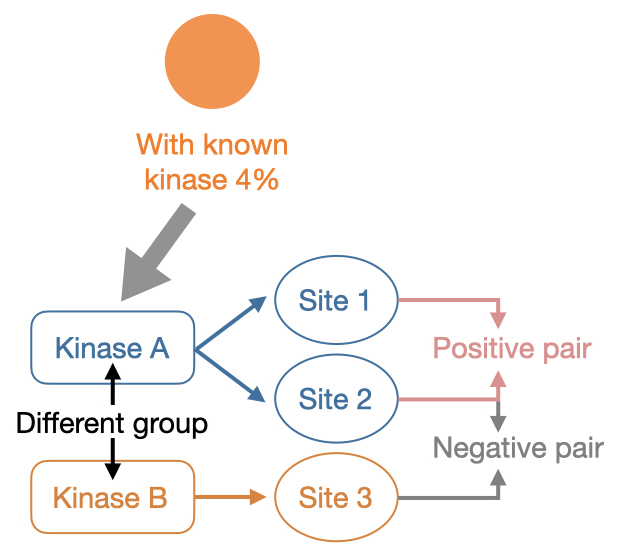

In [2]:
import pandas as pd
import xlrd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import scipy.stats as sts

In [3]:
#Kinase name, family, group
kinases_id=pd.read_excel('KSA/kinase_table.xlsx')
kinases_id.index=kinases_id.Name

#KSA gold standard
K_S_GPS=pd.read_csv('KSA/KSA_gold_standard.csv',index_col=0)

In [4]:
#All sites identified in the CPTAC PanCan datasets
a_file = open("PanCan/all_sites_id_1cancer.pkl", "rb")
All_sites = pickle.load(a_file)
sites=[i for i in All_sites]
seqs=[i.split('|')[3] for i in sites]

In [5]:
#KSA of sites identified in the CPTAC PanCan datasets
K_S_GPS_identified=K_S_GPS[K_S_GPS.seq_15.isin(seqs)]

In [6]:
#KSA gold standard coverage for the sites identified in the PanCan datasets
K_S_GPS_identified=K_S_GPS[K_S_GPS.seq_15.isin(seqs)]

#8 major kinase groups
K_S_GPS_identified=K_S_GPS_identified[K_S_GPS_identified.Group!='Other']

#Leave-one-out kinases for validation
kinases=list(set(K_S_GPS_identified['Gene name']))
kinases.remove('CSNK2A1')
kinases.remove('CSNK1A1')
kinases.remove('CSNK2A2')
kinases=[i for i in kinases if 'family' not in i]

K_S_GPS_identified=K_S_GPS_identified[K_S_GPS_identified['Gene name'].isin(kinases)]

kinases_update=[]
for k in kinases:
    tmp=K_S_GPS_identified[K_S_GPS_identified['Gene name']==k]
    if len(tmp)>=2:
        kinases_update.append(k)
print(len(kinases_update))     
K_S_GPS_identified=K_S_GPS_identified[K_S_GPS_identified['Gene name'].isin(kinases_update)]
print(len(K_S_GPS_identified))

186
4213


In [7]:
#Ave_number of substrates
num_sub=[]
for k in kinases_update:
    tmp=K_S_GPS_identified[K_S_GPS_identified['Gene name']==k]
    num_sub.append(len(tmp))
np.mean(num_sub)

22.650537634408604

In [ ]:
#Construction: Positive and negative pairs
#warning: long running time.

#all positive pairs
pos_site_pairs=[]
for k in kinases_update:
    tmp=K_S_GPS_identified[K_S_GPS_identified['Gene name']==k]
    for i in range(len(tmp)-1):
        for j in range(i+1,len(tmp)):
            if tmp.seq_15.iloc[i]!=tmp.seq_15.iloc[j]:
                pos_site_pairs.append(frozenset([tmp.seq_15.iloc[i],tmp.seq_15.iloc[j]]))
pos_site_pairs=list(set(pos_site_pairs))
print(len(pos_site_pairs))
                
#all negative pairs
seq_lst=list(set(K_S_GPS_identified.seq_15))
neg_site_pairs=[]
for i in range(len(seq_lst)-1):
    for j in range(i+1,len(seq_lst)):
        seq1=seq_lst[i]
        seq2=seq_lst[j]
        tmp1=K_S_GPS[K_S_GPS['seq_15']==seq1]
        tmp2=K_S_GPS[K_S_GPS['seq_15']==seq2]
        if len(set(tmp1.Group).intersection(set(tmp2.Group)))==0:
            if seq1!=seq2:
                neg_site_pairs.append(frozenset([seq1,seq2]))
neg_site_pairs=list(set(neg_site_pairs))
print(len(neg_site_pairs))

#Random site pairs
sites=[i for i in All_sites]
seqs=[i.split('|')[3] for i in sites]
seq_rd1=random.sample(seqs,2000)
seq_rd2=random.sample(seqs,2000)
rd_site_pairs=[]
for s1 in seq_rd1:
    for s2 in seq_rd2:
        if s1!=s2:
            if frozenset([s1,s2]) not in pos_site_pairs:
                rd_site_pairs.append(frozenset([s1,s2]))
rd_site_pairs=list(set(rd_site_pairs))
print(len(rd_site_pairs))

#Save the positive/negative/random site pairs
#Original site pairs have been stored in the folder 'gold_standard_site_pairs'
file_name='CoPheeMap/data_construction/gold_standard_site_pairs/tmp_positive_site_pairs_15mer.txt'
with open(file_name, 'w') as fp:
    for s in pos_site_pairs:
        sites=list(s)
        fp.write("%s\t" % sites[0])
        fp.write("%s\n" % sites[1])

file_name='CoPheeMap/data_construction/gold_standard_site_pairs/tmp_negative_site_pairs_15mer.txt'
with open(file_name, 'w') as fp:
    for s in neg_site_pairs:
        sites=list(s)
        fp.write("%s\t" % sites[0])
        fp.write("%s\n" % sites[1])
        
file_name='CoPheeMap/data_construction/gold_standard_site_pairs/tmp_random_site_pairs_15mer.txt'
with open(file_name, 'w') as fp:
    for s in rd_site_pairs:
        sites=list(s)
        fp.write("%s\t" % sites[0])
        fp.write("%s\n" % sites[1])
        
# Number of positve and negative site pairs
plt.figure(figsize=(5, 5))
plt.bar(['Positive','Negative'],[len(pos_site_pairs),len(neg_site_pairs)], color=['lightcoral','grey'])

plt.xticks(size=15)
plt.yticks(size=20)
plt.xlabel('')
plt.ylabel('# phosphosite pairs',size=20)

plt.show()

In [8]:
data=pd.read_table('CoPheeMap/data_construction/gold_standard_site_pairs/positive_site_pairs_15mer.txt',header=None)
pos_site_pairs=[]
for i in range(len(data)):
    seq1=data.iloc[i,0]
    seq2=data.iloc[i,1]
    pos_site_pairs.append(frozenset([seq1,seq2]))
    
data=pd.read_table('CoPheeMap/data_construction/gold_standard_site_pairs/negative_site_pairs_15mer.txt',header=None)
neg_site_pairs=[]
for i in range(len(data)):
    seq1=data.iloc[i,0]
    seq2=data.iloc[i,1]
    neg_site_pairs.append(frozenset([seq1,seq2]))
    
data=pd.read_table('CoPheeMap/data_construction/gold_standard_site_pairs/random_site_pairs_15mer.txt',header=None)
rd_site_pairs=[]
for i in range(len(data)):
    seq1=data.iloc[i,0]
    seq2=data.iloc[i,1]
    rd_site_pairs.append(frozenset([seq1,seq2]))
#No overlapping between random site pairs and positive site pairs
rd_site_pairs=list(set(rd_site_pairs).difference(set(pos_site_pairs)))

In [15]:
len(pos_site_pairs)

192926

In [16]:
len(neg_site_pairs)

1956116

In [17]:
len(rd_site_pairs)

3224730

Discovery of potential features to distinguish the positive and the negative site pairs
1) site-site abundance correlations
2) sequence similarities
3) kinase interaction profile similarities

#Download phosphoproteomics data to PanCan/Phospho
#Please download File:  Phosphoproteome_BCM_GENCODE_v34_harmonized_v1.zip from https://proteomic.datacommons.cancer.gov/pdc/cptac-pancancer

In [18]:
#Import PanCan datasets
#Phospho
#11 cancer types
BRCA_tumor=pd.read_table('PanCan/Phospho/BRCA_phospho_site_abundance_log2_reference_intensity_normalized_isoform_adjusted_Tumor.cct',index_col='idx')
CCRCC_tumor=pd.read_table('PanCan/Phospho/CCRCC_phospho_site_abundance_log2_reference_intensity_normalized_isoform_adjusted_Tumor.cct',index_col='idx')
COAD_tumor=pd.read_table('PanCan/Phospho/COAD_phospho_site_abundance_log2_reference_intensity_normalized_isoform_adjusted_Tumor.cct',index_col='idx')
GBM_tumor=pd.read_table('PanCan/Phospho/GBM_phospho_site_abundance_log2_reference_intensity_normalized_isoform_adjusted_Tumor.cct',index_col='idx')
HCC_tumor=pd.read_table('PanCan/Phospho/HCC_phospho_site_abundance_log2_reference_intensity_normalized_isoform_adjusted_Tumor.cct',index_col='idx')
HNSCC_tumor=pd.read_table('PanCan/Phospho/HNSCC_phospho_site_abundance_log2_reference_intensity_normalized_isoform_adjusted_Tumor.cct',index_col='idx')
LSCC_tumor=pd.read_table('PanCan/Phospho/LSCC_phospho_site_abundance_log2_reference_intensity_normalized_isoform_adjusted_Tumor.cct',index_col='idx')
LUAD_tumor=pd.read_table('PanCan/Phospho/LUAD_phospho_site_abundance_log2_reference_intensity_normalized_isoform_adjusted_Tumor.cct',index_col='idx')
OV_tumor=pd.read_table('PanCan/Phospho/OV_phospho_site_abundance_log2_reference_intensity_normalized_isoform_adjusted_Tumor.cct',index_col='idx')
PDAC_tumor=pd.read_table('PanCan/Phospho/PDAC_phospho_site_abundance_log2_reference_intensity_normalized_isoform_adjusted_Tumor.cct',index_col='idx')
UCEC_tumor=pd.read_table('PanCan/Phospho/UCEC_phospho_site_abundance_log2_reference_intensity_normalized_isoform_adjusted_Tumor.cct',index_col='idx')

In [19]:
#Phospho
#normal
#9 indications
CCRCC_normal=pd.read_table('PanCan/Phospho/CCRCC_phospho_site_abundance_log2_reference_intensity_normalized_isoform_adjusted_Normal.cct',index_col='idx')
COAD_normal=pd.read_table('PanCan/Phospho/COAD_phospho_site_abundance_log2_reference_intensity_normalized_isoform_adjusted_Normal.cct',index_col='idx')
HCC_normal=pd.read_table('PanCan/Phospho/HCC_phospho_site_abundance_log2_reference_intensity_normalized_isoform_adjusted_Normal.cct',index_col='idx')
HNSCC_normal=pd.read_table('PanCan/Phospho/HNSCC_phospho_site_abundance_log2_reference_intensity_normalized_isoform_adjusted_Normal.cct',index_col='idx')
LSCC_normal=pd.read_table('PanCan/Phospho/LSCC_phospho_site_abundance_log2_reference_intensity_normalized_isoform_adjusted_Normal.cct',index_col='idx')
LUAD_normal=pd.read_table('PanCan/Phospho/LUAD_phospho_site_abundance_log2_reference_intensity_normalized_isoform_adjusted_Normal.cct',index_col='idx')
OV_normal=pd.read_table('PanCan/Phospho/OV_phospho_site_abundance_log2_reference_intensity_normalized_isoform_adjusted_Normal.cct',index_col='idx')
PDAC_normal=pd.read_table('PanCan/Phospho/PDAC_phospho_site_abundance_log2_reference_intensity_normalized_isoform_adjusted_Normal.cct',index_col='idx')
UCEC_normal=pd.read_table('PanCan/Phospho/UCEC_phospho_site_abundance_log2_reference_intensity_normalized_isoform_adjusted_Normal.cct',index_col='idx')

In [20]:
#Missing value filtering
#No more than 80% missing values for each site
tmp=[BRCA_tumor,CCRCC_tumor,COAD_tumor,GBM_tumor,HCC_tumor,HNSCC_tumor,
     LSCC_tumor,LUAD_tumor,OV_tumor,PDAC_tumor,UCEC_tumor]
#tmp=[CCRCC_tumor,COAD_tumor,HCC_tumor,HNSCC_tumor,
#     LSCC_tumor,LUAD_tumor,OV_tumor,PDAC_tumor,UCEC_tumor]
Names=['BRCA','CCRCC','COAD','GBM','HCC','HNSCC','LSCC','LUAD','OV','PDAC','UCEC']
tmp_new=[]
for d in range(len(tmp)):
    DATA=tmp[d]
    ks=[]
    DATA.replace([np.inf, -np.inf], np.nan, inplace=True)
    idx_80=[]
    for k in range(len(DATA)):
        if sum(DATA.iloc[k,:].isna())/len(DATA.iloc[0,:])<=0.8:
            idx_80.append(k)
    DATA=DATA.iloc[idx_80,:]
    tmp_new.append(DATA)

In [11]:
#Missing value filtering
#No more than 80% missing values for each site
tmp_normal=[CCRCC_normal,COAD_normal,HCC_normal,HNSCC_normal,
     LSCC_normal,LUAD_normal,OV_normal,PDAC_normal,UCEC_normal]
Names=['CCRCC','COAD','HCC','HNSCC','LSCC','LUAD','OV','PDAC','UCEC']
tmp_normal_new=[]
for d in range(len(tmp_normal)):
    DATA=tmp_normal[d]
    ks=[]
    DATA.replace([np.inf, -np.inf], np.nan, inplace=True)
    idx_80=[]
    for k in range(len(DATA)):
        if sum(DATA.iloc[k,:].isna())/len(DATA.iloc[0,:])<=0.8:
            idx_80.append(k)
    DATA=DATA.iloc[idx_80,:]
    tmp_normal_new.append(DATA)

In [296]:
#Site-level PCC for the positive pairs in the PanCan
#at least 20 sample overlapping for the two sites
for i in range(len(tmp_new)):
    print(i)
    data=tmp_new[i]
    all_seqs=[k.split('|')[3] for k in data.index]
    data['seq_15']=np.array(all_seqs)
    corr_pos=[]
    sitepair=[]
    for s in pos_site_pairs:
        seq1=list(s)[0]
        seq2=list(s)[1]
        if (seq1 in all_seqs) and (seq2 in all_seqs):
            s1_abundance=data[data.seq_15==seq1].iloc[0,:-1]
            s2_abundance=data[data.seq_15==seq2].iloc[0,:-1]
            nas = np.logical_or(s1_abundance.isna(), s2_abundance.isna())
            site1_nas=s1_abundance[~nas]
            site2_nas=s2_abundance[~nas]
            site1=data[data.seq_15==seq1].index[0]
            site2=data[data.seq_15==seq2].index[0]
            if len(site1_nas)>=20:
                corr_pos.append(sts.pearsonr(site1_nas, site2_nas)[0])
                sitepair.append('*'.join([site1,site2]))
    df=pd.DataFrame()
    df['pairs']=np.array(sitepair)
    df['PCC']=np.array(corr_pos)
    file_name=''.join(['CoPheeMap/data_construction/positive_pcc/',Names[i],'_pos_pcc_sitepairs.csv'])
    df.to_csv(file_name)

0


/var/folders/2k/p13z68bx7p9fvh4xn3mbjn_r0000gr/T/ipykernel_3522/2919715465.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['seq_15']=np.array(all_seqs)


1
2
3
4
5
6
7
8
9
10


In [ ]:
#Site-level PCC for the negative pairs in the PanCan
#at least 20 sample overlapping for the two sites
for i in range(len(tmp_new)):
    print(i)
    data=tmp_new[i]
    all_seqs=[k.split('|')[3] for k in data.index]
    data['seq_15']=np.array(all_seqs)
    corr_neg=[]
    sitepair=[]
    for s in neg_site_pairs:
        seq1=list(s)[0]
        seq2=list(s)[1]
        if (seq1 in all_seqs) and (seq2 in all_seqs):
            s1_abundance=data[data.seq_15==seq1].iloc[0,:-1]
            s2_abundance=data[data.seq_15==seq2].iloc[0,:-1]
            nas = np.logical_or(s1_abundance.isna(), s2_abundance.isna())
            site1_nas=s1_abundance[~nas]
            site2_nas=s2_abundance[~nas]
            site1=data[data.seq_15==seq1].index[0]
            site2=data[data.seq_15==seq2].index[0]
            if len(site1_nas)>=20:
                corr_neg.append(sts.pearsonr(site1_nas, site2_nas)[0])
                sitepair.append('*'.join([site1,site2]))
    df=pd.DataFrame()
    df['pairs']=np.array(sitepair)
    df['PCC']=np.array(corr_neg)
    file_name=''.join(['CoPheeMap/data_construction/negative_pcc/',Names[i],'_neg_pcc_sitepairs.csv'])
    df.to_csv(file_name)

0


/var/folders/2k/p13z68bx7p9fvh4xn3mbjn_r0000gr/T/ipykernel_3522/1614703564.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['seq_15']=np.array(all_seqs)


1
2
3
4
5
6
7
8
9


In [ ]:
#Site-level PCC for the random pairs in the PanCan
#at least 20 sample overlapping for the two sites
for i in range(7,len(tmp_new)):
    print(i)
    data=tmp_new[i]
    all_seqs=[k.split('|')[3] for k in data.index]
    data['seq_15']=np.array(all_seqs)
    corr_neg=[]
    sitepair=[]
    for s in rd_site_pairs:
        seq1=list(s)[0]
        seq2=list(s)[1]
        if (seq1 in all_seqs) and (seq2 in all_seqs):
            s1_abundance=data[data.seq_15==seq1].iloc[0,:-1]
            s2_abundance=data[data.seq_15==seq2].iloc[0,:-1]
            nas = np.logical_or(s1_abundance.isna(), s2_abundance.isna())
            site1_nas=s1_abundance[~nas]
            site2_nas=s2_abundance[~nas]
            site1=data[data.seq_15==seq1].index[0]
            site2=data[data.seq_15==seq2].index[0]
            if len(site1_nas)>=20:
                corr_neg.append(sts.pearsonr(site1_nas, site2_nas)[0])
                sitepair.append('*'.join([site1,site2]))
    df=pd.DataFrame()
    df['pairs']=np.array(sitepair)
    df['PCC']=np.array(corr_neg)
    file_name=''.join(['CoPheeMap/data_construction/random_pcc/',Names[i],'_rd_pcc_sitepairs.csv'])
    df.to_csv(file_name)

In [21]:
results_pos=[]
for k in range(11):
    filename=''.join(['CoPheeMap/data_construction/positive_pcc/',Names[k],'_pos_pcc_sitepairs.csv'])
    data=pd.read_csv(filename,index_col=0)
    results_pos.append(data)
results_neg=[]
for k in range(11):
    filename=''.join(['CoPheeMap/data_construction/negative_pcc/',Names[k],'_neg_pcc_sitepairs.csv'])
    data=pd.read_csv(filename,index_col=0)
    results_neg.append(data)

In [17]:
import seaborn as sns
from statannot import add_stat_annotation

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

PDAC_Positive v.s. PDAC_Negative: t-test independent samples with Bonferroni correction, P_val=0.000e+00 stat=4.720e+01
UCEC_Positive v.s. UCEC_Negative: t-test independent samples with Bonferroni correction, P_val=0.000e+00 stat=7.399e+01
OV_Positive v.s. OV_Negative: t-test independent samples with Bonferroni correction, P_val=2.598e-283 stat=3.606e+01
CCRCC_Positive v.s. CCRCC_Negative: t-test independent samples with Bonferroni correction, P_val=0.000e+00 stat=4.298e+01
BRCA_Positive v.s. BRCA_Negative: t-test independent samples with Bonferroni correction, P_val=0.000e+00 stat=6.236e+01
COAD_Positive v.s. COAD_Negative: t-test independent samples with Bonferroni correction, P_val=0.000e+00 stat=4.067e+01
GBM_Positive v.s. GBM_Negative: t-test independent samples with Bonferroni correction, P_val=0.000e+00 stat=8.873e+01

/var/folders/2k/p13z68bx7p9fvh4xn3mbjn_r0000gr/T/ipykernel_84213/814411574.py:42: MatplotlibDeprecationWarning: 
The 'optimize' parameter of print_jpg() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use pil_kwargs={'optimize': ...} instead. If any parameter follows 'optimize', they should be passed as keyword, not positionally.
  plt.savefig(''.join(['CoPheeMap/figures/PCC_pos.jpeg']),bbox_inches='tight',dpi=300,pad_inches=0.1,optimize=True,orientation='portrait')


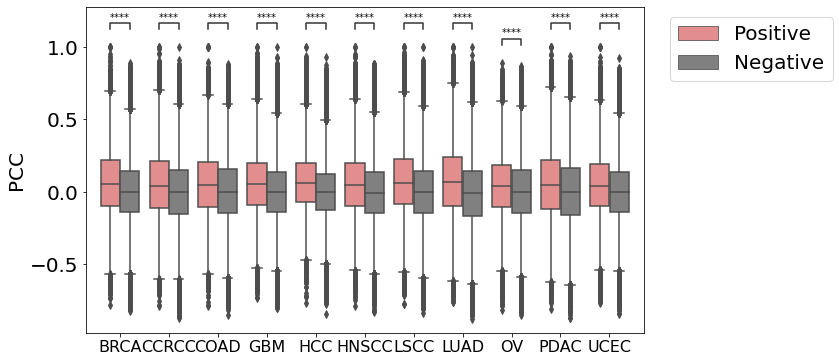

In [840]:
#PCC
#Comparison between the positive and the negative site pairs
PCC1=results_pos[0].PCC.values
tumor1=np.repeat(Names[0],len(PCC1))
for i in range(1,11):
    PCC1=np.append(PCC1,results_pos[i].PCC.values)
    tumor1=np.append(tumor1, np.repeat(Names[i],len(results_pos[i])))
label1=np.repeat('Positive',len(PCC1))
PCC2=results_neg[0].PCC.values
tumor2=np.repeat(Names[0],len(results_neg[0]))
for i in range(1,11):
    PCC2=np.append(PCC2,results_neg[i].PCC.values)
    tumor2=np.append(tumor2, np.repeat(Names[i],len(results_neg[i])))
label2=np.repeat('Negative',len(PCC2))
df={'PCC':np.append(PCC1,PCC2),'tumor':np.append(tumor1,tumor2),
                         'label':np.append(label1,label2)}
df=pd.DataFrame(df)
plt.figure(figsize=(10, 6))
x = "tumor"
y = "PCC"
hue = "label"
ax = sns.boxplot(data=df, x=x, y=y, hue=hue,palette=['lightcoral','grey'])
add_stat_annotation(ax, data=df, x=x, y=y, hue=hue,
                    box_pairs=[(("BRCA", "Positive"), ("BRCA", "Negative")),
                                 (("CCRCC", "Positive"), ("CCRCC", "Negative")),
                                 (("COAD", "Positive"), ("COAD", "Negative")),
                                 (("GBM", "Positive"), ("GBM", "Negative")),
                                 (("HCC", "Positive"), ("HCC", "Negative")),
                                 (("HNSCC", "Positive"), ("HNSCC", "Negative")),
                                 (("LSCC", "Positive"), ("LSCC", "Negative")),
                                 (("LUAD", "Positive"), ("LUAD", "Negative")),
                                 (("OV", "Positive"), ("OV", "Negative")),
                                 (("PDAC", "Positive"), ("PDAC", "Negative")),
                                 (("UCEC", "Positive"), ("UCEC", "Negative"))
                                ],
                    test='t-test_ind', text_format='star', loc='inside', verbose=2)
plt.xticks(size=16)
plt.yticks(size=20)
plt.xlabel('')
plt.ylabel('PCC',size=20)
plt.legend(loc='upper left', bbox_to_anchor=(1.03, 1),fontsize=20)
plt.savefig(''.join(['CoPheeMap/figures/PCC_pos.jpeg']),bbox_inches='tight',dpi=300,pad_inches=0.1,optimize=True,orientation='portrait')
plt.show()

In [619]:
#Import PanCan datasets
#data construction
#Protein
BRCA_tumor_pro=pd.read_table('PanCan/Protein/BRCA_proteomics_gene_abundance_log2_reference_intensity_normalized_Tumor.cct',index_col='idx')
CCRCC_tumor_pro=pd.read_table('PanCan/Protein/CCRCC_proteomics_gene_abundance_log2_reference_intensity_normalized_Tumor.cct',index_col='idx')
COAD_tumor_pro=pd.read_table('PanCan/Protein/COAD_proteomics_gene_abundance_log2_reference_intensity_normalized_Tumor.cct',index_col='idx')
GBM_tumor_pro=pd.read_table('PanCan/Protein/GBM_proteomics_gene_abundance_log2_reference_intensity_normalized_Tumor.cct',index_col='idx')
HCC_tumor_pro=pd.read_table('PanCan/Protein/HCC_proteomics_gene_abundance_log2_reference_intensity_normalized_Tumor.cct',index_col='idx')
HNSCC_tumor_pro=pd.read_table('PanCan/Protein/HNSCC_proteomics_gene_abundance_log2_reference_intensity_normalized_Tumor.cct',index_col='idx')
LSCC_tumor_pro=pd.read_table('PanCan/Protein/LSCC_proteomics_gene_abundance_log2_reference_intensity_normalized_Tumor.cct',index_col='idx')
LUAD_tumor_pro=pd.read_table('PanCan/Protein/LUAD_proteomics_gene_abundance_log2_reference_intensity_normalized_Tumor.cct',index_col='idx')
OV_tumor_pro=pd.read_table('PanCan/Protein/OV_proteomics_gene_abundance_log2_reference_intensity_normalized_Tumor.cct',index_col='idx')
PDAC_tumor_pro=pd.read_table('PanCan/Protein/PDAC_proteomics_gene_abundance_log2_reference_intensity_normalized_Tumor.cct',index_col='idx')
UCEC_tumor_pro=pd.read_table('PanCan/Protein/UCEC_proteomics_gene_abundance_log2_reference_intensity_normalized_Tumor.cct',index_col='idx')

In [620]:
tmp_new=[]
tmp=[BRCA_tumor_pro,CCRCC_tumor_pro,COAD_tumor_pro,GBM_tumor_pro,HCC_tumor_pro,HNSCC_tumor_pro,
     LSCC_tumor_pro,LUAD_tumor_pro,OV_tumor_pro,PDAC_tumor_pro,UCEC_tumor_pro]
Names=['BRCA','CCRCC','COAD','GBM','HCC','HNSCC','LSCC','LUAD','OV','PDAC','UCEC']
for d in range(len(tmp)):
    DATA=tmp[d]
    ks=[]
    DATA.replace([np.inf, -np.inf], np.nan, inplace=True)
    idx_80=[]
    for k in range(len(DATA)):
        if sum(DATA.iloc[k,:].isna())/len(DATA.iloc[0,:])<=0.8:
            idx_80.append(k)
    DATA=DATA.iloc[idx_80,:]
    tmp_new.append(DATA)

In [621]:
#Protein-level PCC for the positive pairs in the PanCan
#at least 20 sample overlapping for the two sites
for i in range(len(results_pos)):
    print(i)
    data=results_pos[i]
    data_pro=tmp_new[i]
    corr_pos=[]
    sitepair=[]
    Index2=[]
    site1=[s.split('*')[0] for s in data.pairs]
    site2=[s.split('*')[1] for s in data.pairs]
    PRO1=[p.split('|')[0] for p in site1]
    PRO2=[p.split('|')[0] for p in site2]
    for s in range(len(PRO1)):
        pro1=PRO1[s]
        pro2=PRO2[s]
        if pro1!=pro2:
            if (pro1 in data_pro.index) and (pro2 in data_pro.index):
                s1_abundance=data_pro.loc[pro1][0:-1]
                s2_abundance=data_pro.loc[pro2][0:-1]
                nas = np.logical_or(s1_abundance.isna(), s2_abundance.isna())
                site1_nas=s1_abundance[~nas]
                site2_nas=s2_abundance[~nas]
                if len(site1_nas)>=20:
                    corr_pos.append(sts.pearsonr(site1_nas, site2_nas)[0])
                    Index2.append(s)
                    sitepair.append('*'.join([pro1,pro2]))
    df=pd.DataFrame()
    df['pairs']=np.array(sitepair)
    df['Index2']=np.array(Index2)
    df['PCC']=np.array(corr_pos)
    file_name=''.join(['CoPheeMap/data_construction/positive_pcc/',Names[i],'_pos_pcc_propairs.csv'])
    df.to_csv(file_name)

0
1
2
3
4
5
6
7
8
9
10


In [307]:
#Protein-level PCC for the negative pairs in the PanCan
#at least 20 sample overlapping for the two sites
for i in range(len(results_neg)):
    print(i)
    data=results_neg[i]
    data_pro=tmp_new[i]
    corr_neg=[]
    sitepair=[]
    Index2=[]
    site1=[s.split('*')[0] for s in data.pairs]
    site2=[s.split('*')[1] for s in data.pairs]
    PRO1=[p.split('|')[0] for p in site1]
    PRO2=[p.split('|')[0] for p in site2]
    for s in range(len(PRO1)):
        pro1=PRO1[s]
        pro2=PRO2[s]
        if pro1!=pro2:
            if (pro1 in data_pro.index) and (pro2 in data_pro.index):
                s1_abundance=data_pro.loc[pro1][0:-1]
                s2_abundance=data_pro.loc[pro2][0:-1]
                nas = np.logical_or(s1_abundance.isna(), s2_abundance.isna())
                site1_nas=s1_abundance[~nas]
                site2_nas=s2_abundance[~nas]
                if len(site1_nas)>=20:
                    Index2.append(s)
                    corr_neg.append(sts.pearsonr(site1_nas, site2_nas)[0])
                    sitepair.append('*'.join([pro1,pro2]))
    df=pd.DataFrame()
    df['pairs']=np.array(sitepair)
    df['Index2']=np.array(Index2)
    df['PCC']=np.array(corr_neg)
    file_name=''.join(['CoPheeMap/data_construction/negative_pcc/',Names[i],'_neg_pcc_propairs.csv'])
    df.to_csv(file_name)

0
1
2
3
4
5
6
7
8
9
10


In [16]:
results_pos_pro=[]
for k in range(11):
    filename=''.join(['CoPheeMap/data_construction/positive_pcc/',Names[k],'_pos_pcc_propairs.csv'])
    data=pd.read_csv(filename,index_col=0)
    results_pos_pro.append(data)
results_neg_pro=[]
for k in range(11):
    filename=''.join(['CoPheeMap/data_construction/negative_pcc/',Names[k],'_neg_pcc_propairs.csv'])
    data=pd.read_csv(filename,index_col=0)
    results_neg_pro.append(data)

In [17]:
results_pos_site=[]
for k in range(len(results_pos_pro)):
    data1=results_pos_pro[k]
    data2=results_pos[k]
    data2=data2.iloc[data1.Index2.tolist(),:]
    data2['PCC_pro']=np.array(data1.PCC)
    data2=data2.replace(1,np.nan)
    results_pos_site.append(data2)
results_neg_site=[]
for k in range(len(results_neg_pro)):
    data1=results_neg_pro[k]
    data2=results_neg[k]
    data2=data2.iloc[data1.Index2.tolist(),:]
    data2['PCC_pro']=np.array(data1.PCC)
    data2=data2.replace(1,np.nan)
    results_neg_site.append(data2)

/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_12691/2240201662.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data2['PCC_pro']=np.array(data1.PCC)
/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_12691/2240201662.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data2['PCC_pro']=np.array(data1.PCC)
/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_12691/2240201662.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usin

/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_12691/2240201662.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data2['PCC_pro']=np.array(data1.PCC)


In [18]:
import math

In [19]:
results_pos_sites_w_2dLLR=[]
results_neg_sites_w_2dLLR=[]
for k in range(11):
    results={}
    data_pos=results_pos_site[k]
    data_neg=results_neg_site[k]
    data_pos['2d_LLR']=np.repeat(0,len(data_pos))
    data_neg['2d_LLR']=np.repeat(0,len(data_neg))
    O=len(data_pos)/len(data_neg)
    for i in range(1,20):
        LLR=[]
        threshold_low=-1+i*0.1
        threshold_high=-1+i*0.1+0.1
        name=''.join(['bin',str(i)])
        for j in range(19,0,-1):
            threshold_low_2=-1+j*0.1
            threshold_high_2=-1+j*0.1+0.1
            tmp=data_pos[data_pos.PCC<threshold_high]
            tmp=tmp[tmp.PCC>=threshold_low]
            tmp=tmp[tmp.PCC_pro>=threshold_low_2]
            tmp=tmp[tmp.PCC_pro<threshold_high_2]
            num_pos=len(tmp)
            num_pos=num_pos+1
            tmp2=data_neg[data_neg.PCC<threshold_high]
            tmp2=tmp2[tmp2.PCC>=threshold_low]
            tmp2=tmp2[tmp2.PCC_pro>=threshold_low_2]
            tmp2=tmp2[tmp2.PCC_pro<threshold_high_2]
            num_neg=len(tmp2)
            num_neg=num_neg+1/O
            Index=tmp.index
            data_pos['2d_LLR'].loc[Index]=math.log(num_pos/num_neg/O)
            Index=tmp2.index
            data_neg['2d_LLR'].loc[Index]=math.log(num_pos/num_neg/O)
            LLR.append(math.log(num_pos/num_neg/O))
            
        results[name]=np.array(LLR)
    results=pd.DataFrame(results)
    results_pos_sites_w_2dLLR.append(data_pos)
    results_neg_sites_w_2dLLR.append(data_neg)

/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_12691/586885072.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pos['2d_LLR'].loc[Index]=math.log(num_pos/num_neg/O)
/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_12691/586885072.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_neg['2d_LLR'].loc[Index]=math.log(num_pos/num_neg/O)
/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_12691/586885072.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

In [136]:
for i in range(11):
    tmp=results_pos_sites_w_2dLLR[i]
    tmp=tmp[tmp['PCC_pro']< -0.5]
    tmp=tmp[tmp['PCC']<0]
    tmp=tmp[tmp['2d_LLR']>0]
    lst=tmp.pairs.tolist()
    sites1=[i.split('*')[0] for i in lst]
    sites2=[i.split('*')[1] for i in lst]
    kinases1=[]
    kinases2=[]
    for s in range(len(sites1)):
        site1=sites1[s]
        site2=sites2[s]
        seq1=site1.split('|')[3]
        seq2=site1.split('|')[3]
        kinases1.append(';'.join(K_S_GPS_identified[K_S_GPS_identified.seq_15==seq1]['Gene name'].tolist()))
        kinases2.append(';'.join(K_S_GPS_identified[K_S_GPS_identified.seq_15==seq2]['Gene name'].tolist()))
    df=pd.DataFrame()
    df['PCC_site']=tmp.PCC.tolist()
    df['PCC_pro']=tmp.PCC_pro.tolist()
    df['2d_LLR']=tmp['2d_LLR'].tolist()
    df['site1']=sites1
    df['site2']=sites2
    df['kinase1']=kinases1
    df['kinase2']=kinases2
    df.to_csv(''.join(['CoPheeMap/',Names[i],'_LLR_bottomarea.csv']))

/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_12691/1460618861.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pos['2d_LLR'].loc[Index]=math.log(num_pos/num_neg/O)
/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_12691/1460618861.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_neg['2d_LLR'].loc[Index]=math.log(num_pos/num_neg/O)


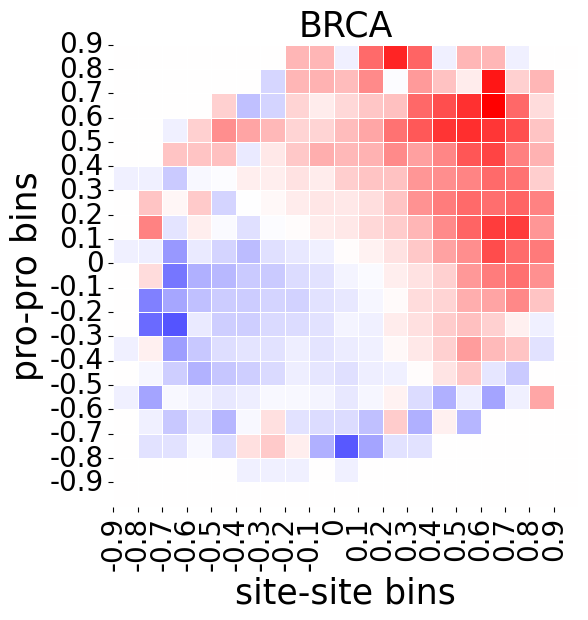

/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_12691/1460618861.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pos['2d_LLR'].loc[Index]=math.log(num_pos/num_neg/O)
/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_12691/1460618861.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_neg['2d_LLR'].loc[Index]=math.log(num_pos/num_neg/O)


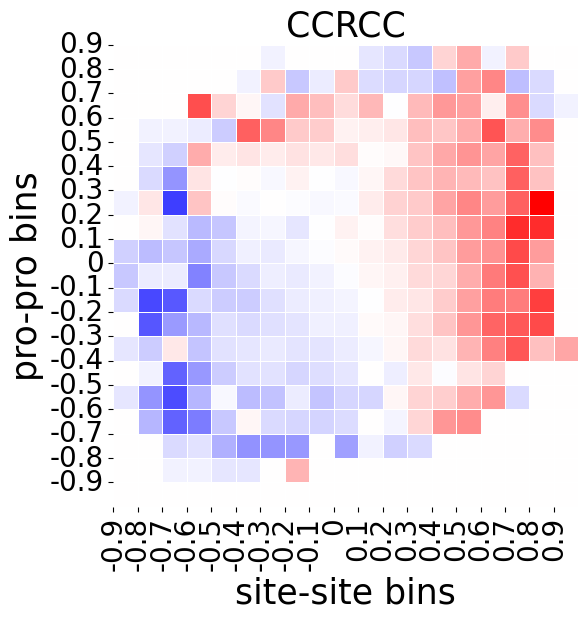

/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_12691/1460618861.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pos['2d_LLR'].loc[Index]=math.log(num_pos/num_neg/O)
/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_12691/1460618861.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_neg['2d_LLR'].loc[Index]=math.log(num_pos/num_neg/O)


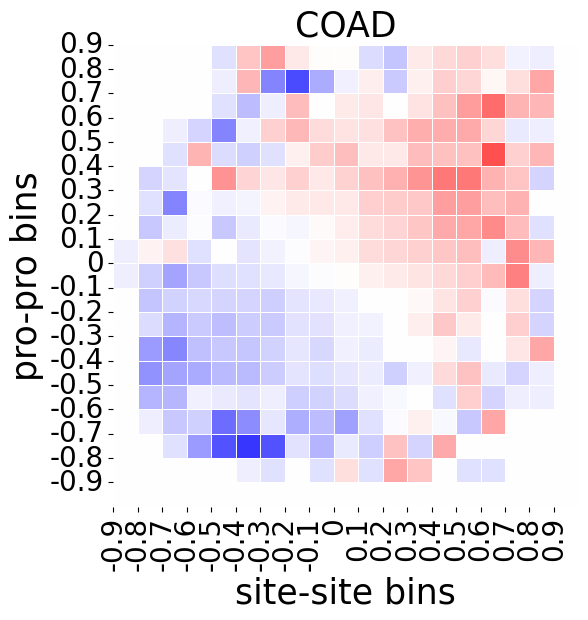

/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_12691/1460618861.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pos['2d_LLR'].loc[Index]=math.log(num_pos/num_neg/O)
/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_12691/1460618861.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_neg['2d_LLR'].loc[Index]=math.log(num_pos/num_neg/O)


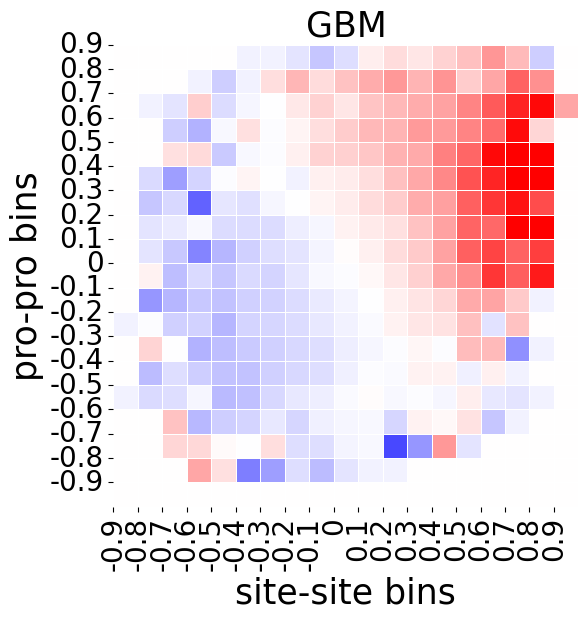

/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_12691/1460618861.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pos['2d_LLR'].loc[Index]=math.log(num_pos/num_neg/O)
/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_12691/1460618861.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_neg['2d_LLR'].loc[Index]=math.log(num_pos/num_neg/O)


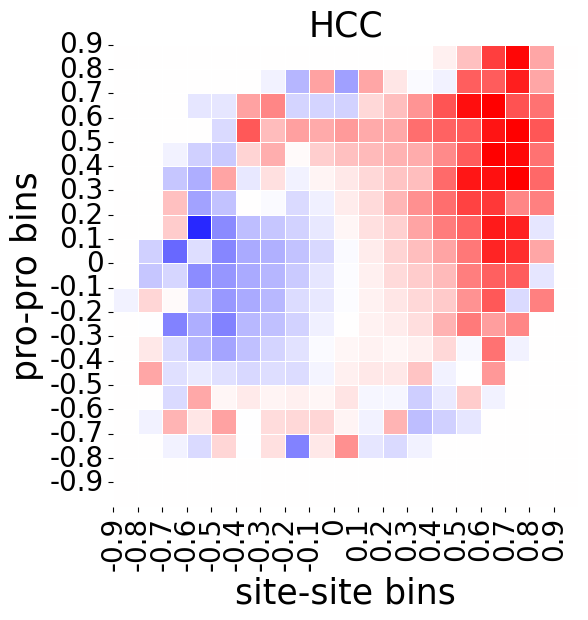

/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_12691/1460618861.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pos['2d_LLR'].loc[Index]=math.log(num_pos/num_neg/O)
/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_12691/1460618861.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_neg['2d_LLR'].loc[Index]=math.log(num_pos/num_neg/O)


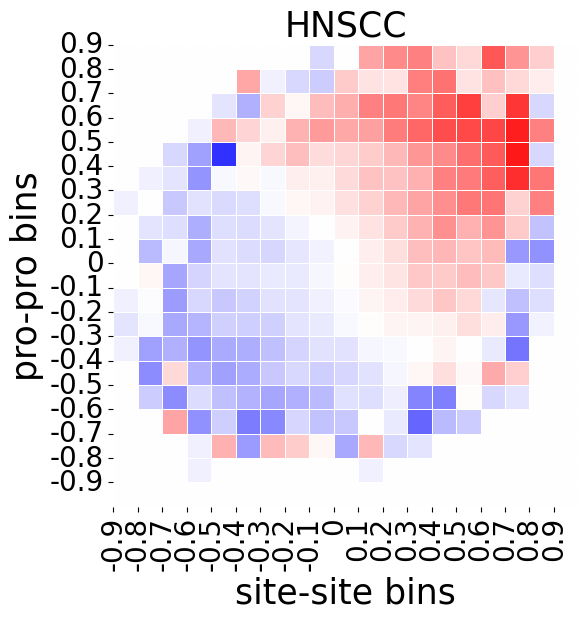

/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_12691/1460618861.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pos['2d_LLR'].loc[Index]=math.log(num_pos/num_neg/O)
/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_12691/1460618861.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_neg['2d_LLR'].loc[Index]=math.log(num_pos/num_neg/O)


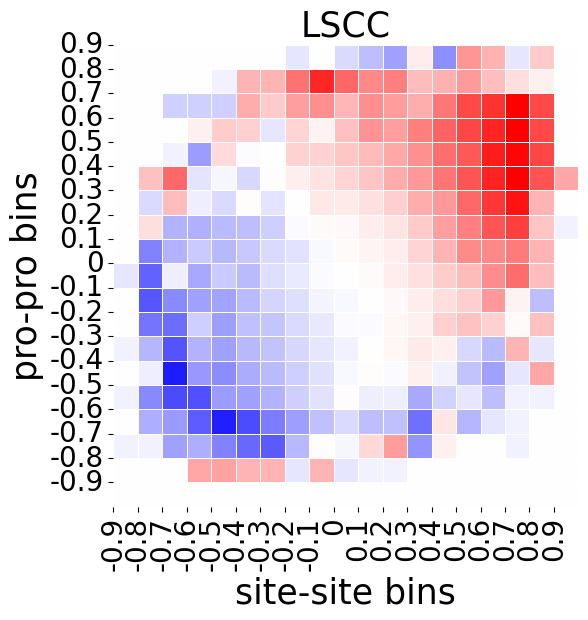

/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_12691/1460618861.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pos['2d_LLR'].loc[Index]=math.log(num_pos/num_neg/O)
/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_12691/1460618861.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_neg['2d_LLR'].loc[Index]=math.log(num_pos/num_neg/O)


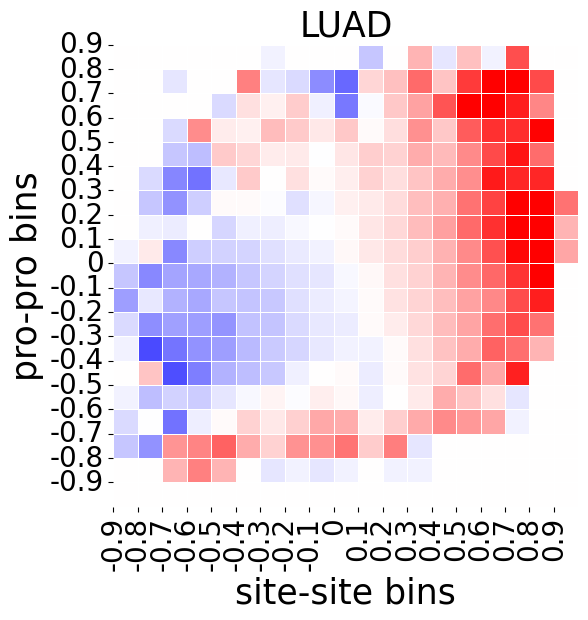

/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_12691/1460618861.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pos['2d_LLR'].loc[Index]=math.log(num_pos/num_neg/O)
/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_12691/1460618861.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_neg['2d_LLR'].loc[Index]=math.log(num_pos/num_neg/O)


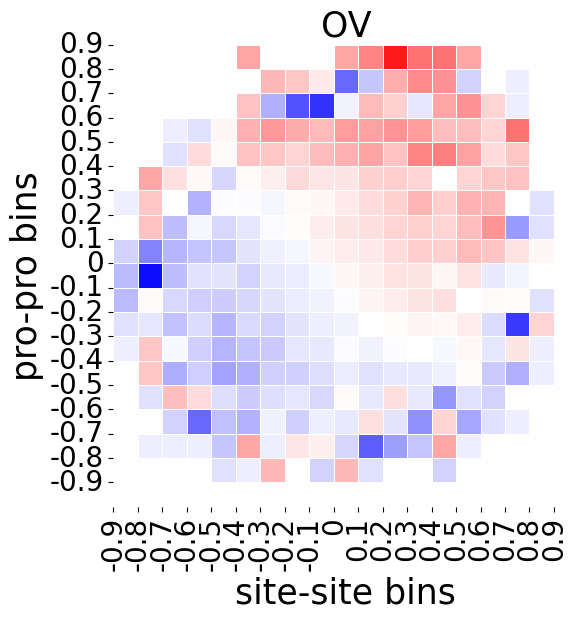

/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_12691/1460618861.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pos['2d_LLR'].loc[Index]=math.log(num_pos/num_neg/O)
/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_12691/1460618861.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_neg['2d_LLR'].loc[Index]=math.log(num_pos/num_neg/O)


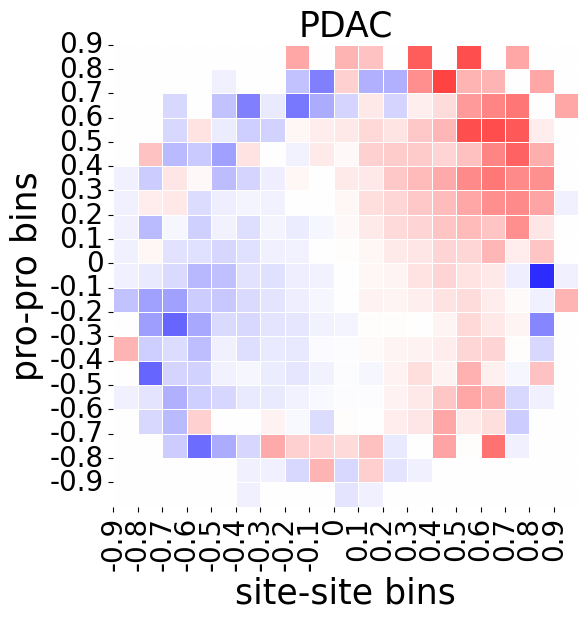

/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_12691/1460618861.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pos['2d_LLR'].loc[Index]=math.log(num_pos/num_neg/O)
/var/folders/s_/ypslfjr17j5d3n3ypmjhz1f80000gq/T/ipykernel_12691/1460618861.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_neg['2d_LLR'].loc[Index]=math.log(num_pos/num_neg/O)


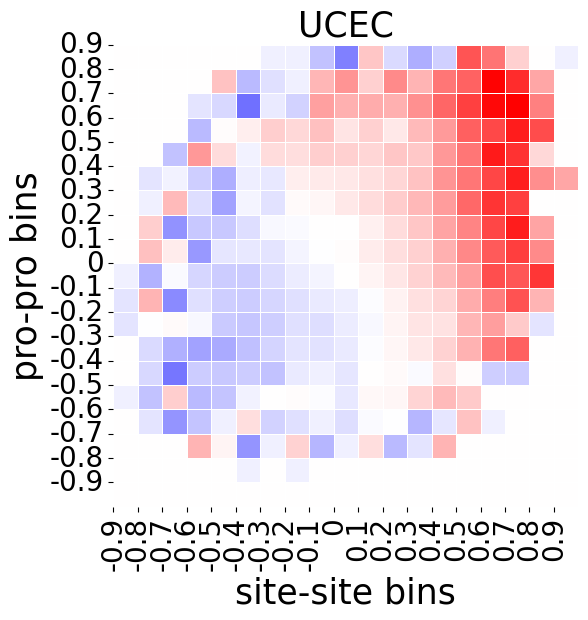

In [26]:
#2D LLR plot
results_pos_sites_w_2dLLR=[]
results_neg_sites_w_2dLLR=[]
for k in range(11):
    results={}
    data_pos=results_pos_site[k]
    data_neg=results_neg_site[k]
    data_pos['2d_LLR']=np.repeat(0,len(data_pos))
    data_neg['2d_LLR']=np.repeat(0,len(data_neg))
    O=len(data_pos)/len(data_neg)
    for i in range(1,20):
        LLR=[]
        threshold_low=-1+i*0.1
        threshold_high=-1+i*0.1+0.1
        name=''.join(['bin',str(i)])
        for j in range(19,0,-1):
            threshold_low_2=-1+j*0.1
            threshold_high_2=-1+j*0.1+0.1
            tmp=data_pos[data_pos.PCC<threshold_high]
            tmp=tmp[tmp.PCC>=threshold_low]
            tmp=tmp[tmp.PCC_pro>=threshold_low_2]
            tmp=tmp[tmp.PCC_pro<threshold_high_2]
            num_pos=len(tmp)
            num_pos=num_pos+1
            tmp2=data_neg[data_neg.PCC<threshold_high]
            tmp2=tmp2[tmp2.PCC>=threshold_low]
            tmp2=tmp2[tmp2.PCC_pro>=threshold_low_2]
            tmp2=tmp2[tmp2.PCC_pro<threshold_high_2]
            num_neg=len(tmp2)
            num_neg=num_neg+1/O
            Index=tmp.index
            data_pos['2d_LLR'].loc[Index]=math.log(num_pos/num_neg/O)
            Index=tmp2.index
            data_neg['2d_LLR'].loc[Index]=math.log(num_pos/num_neg/O)
            LLR.append(math.log(num_pos/num_neg/O))
            
        results[name]=np.array(LLR)
    results=pd.DataFrame(results)
    results_pos_sites_w_2dLLR.append(data_pos)
    results_neg_sites_w_2dLLR.append(data_neg)
    
    plt.figure(figsize=(6, 6))
    
    sns.heatmap(results,linewidths=.5,cmap="bwr",center=0,vmin=-2,vmax=2, cbar=False)

    plt.xticks(np.arange(19), ('-0.9','-0.8','-0.7',
                               '-0.6','-0.5','-0.4',
                               '-0.3','-0.2','-0.1',
                               '0','0.1','0.2',
                               '0.3','0.4','0.5',
                               '0.6','0.7','0.8','0.9'),rotation=90,ha='center',size=20)
    plt.xlabel('site-site bins',size=25)
    plt.yticks(np.arange(19), ('0.9','0.8','0.7',
                               '0.6','0.5','0.4',
                               '0.3','0.2','0.1',
                               '0','-0.1','-0.2',
                               '-0.3','-0.4','-0.5',
                               '-0.6','-0.7','-0.8','-0.9'),rotation=0, ha='right',size=20)
    plt.ylabel('pro-pro bins',size=25)
    plt.title(Names[k],size=25)
    #plt.savefig(''.join(['CoPheeMap/figures/heatmap_2d_',Names[k],'.jpeg']),bbox_inches='tight',dpi=300,pad_inches=0.1,orientation='portrait')
    plt.show()

In [628]:
#Ground truth construction with PCCs from PanCan
combined_cancer_pos=pd.DataFrame()
for i in range(11):
    data=results_pos[i]
    site1=[s.split('*')[0] for s in data.pairs]
    site2=[s.split('*')[1] for s in data.pairs]
    names=[frozenset([site1[j],site2[j]]) for j in range(len(site1))]
    data.index=list(set(names))
    data=data[['PCC']]
    data.rename(columns = {'PCC':''.join(['PCC_',Names[i]])}, inplace = True)
    combined_cancer_pos=pd.concat([combined_cancer_pos,data],axis=1)
    
combined_cancer_neg=pd.DataFrame()
for i in range(11):
    data=results_neg[i]
    site1=[s.split('*')[0] for s in data.pairs]
    site2=[s.split('*')[1] for s in data.pairs]
    names=[frozenset([site1[j],site2[j]]) for j in range(len(site1))]
    data.index=list(set(names))
    data=data[['PCC']]
    data.rename(columns = {'PCC':''.join(['PCC_',Names[i]])}, inplace = True)
    combined_cancer_neg=pd.concat([combined_cancer_neg,data],axis=1)

/Users/wj6/opt/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [629]:
#sequence similarities
from Bio.SubsMat import MatrixInfo
blosum = MatrixInfo.blosum62
def score_match(pair, matrix):
    if pair not in matrix:
        return matrix[(tuple(reversed(pair)))]
    else:
        return matrix[pair]
def score_pairwise(seq1, seq2, matrix, gap_s, gap_e):
    score = 0
    gap = False
    for i in range(len(seq1)):
        pair = (seq1[i], seq2[i])
        if not gap:
            if ('_' in pair):
                gap = True
                score += gap_s
            else:
                score += score_match(pair, matrix)
        else:
            if '_' not in pair:
                gap = False
                score += score_match(pair, matrix)
            else:
                score += gap_e
    return score

In [630]:
combined_cancer_pos['seq_simi']=np.repeat(np.nan,len(combined_cancer_pos))
combined_cancer_neg['seq_simi']=np.repeat(np.nan,len(combined_cancer_neg))

In [631]:
#Sequence similarities
simi=[]
for i in range(len(combined_cancer_pos)):
    name1=list(combined_cancer_pos.index[i])[0]
    name2=list(combined_cancer_pos.index[i])[1]
    seq1=name1.split('|')[3]
    seq2=name2.split('|')[3]
    seq1=seq1[0:7]+'_'+seq1[8:16]
    seq2=seq2[0:7]+'_'+seq2[8:16]
    simi.append(score_pairwise(seq1, seq2, blosum, 0, 0))
combined_cancer_pos['seq_simi']=np.array(simi)

    
#simi=[]
#for i in range(len(combined_cancer_neg)):
#    name1=list(combined_cancer_neg.index[i])[0]
#    name2=list(combined_cancer_neg.index[i])[1]

#    seq1=name1.split('|')[3]
#    seq2=name2.split('|')[3]
#    seq1=seq1[0:7]+'_'+seq1[8:16]
#    seq2=seq2[0:7]+'_'+seq2[8:16]
#    simi.append(score_pairwise(seq1, seq2, blosum, 0, 0))
#combined_cancer_neg['seq_simi']=np.array(simi)

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Positive v.s. Negative: t-test independent samples with Bonferroni correction, P_val=0.000e+00 stat=3.223e+02


/var/folders/2k/p13z68bx7p9fvh4xn3mbjn_r0000gr/T/ipykernel_84213/4131592672.py:18: MatplotlibDeprecationWarning: 
The 'optimize' parameter of print_jpg() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use pil_kwargs={'optimize': ...} instead. If any parameter follows 'optimize', they should be passed as keyword, not positionally.
  plt.savefig(''.join(['CoPheeMap/figures/seq_simi_pos.jpeg']),bbox_inches='tight',dpi=300,pad_inches=0.1,optimize=True,orientation='portrait')


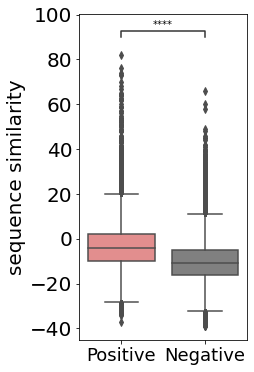

In [846]:
simi_pos=combined_cancer_pos.seq_simi.tolist()
simi_neg=combined_cancer_neg.seq_simi.tolist()
df=pd.DataFrame({'Similarity':np.append(np.array(simi_pos),np.array(simi_neg)),
                 'Label':np.append(np.repeat('Positive',len(simi_pos)),
                                   np.repeat('Negative',len(simi_neg)))})
plt.figure(figsize=(3, 6))
x='Label'
y='Similarity'
ax = sns.boxplot(data=df,x=x,y=y, palette=['lightcoral','grey'])
add_stat_annotation(ax, data=df, x=x, y=y,
                    box_pairs=[(('Positive','Negative'))],
                    test='t-test_ind', text_format='star', loc='inside', verbose=2)
plt.xticks(size=18)
plt.yticks(size=20)
plt.xlabel('')
plt.ylabel('sequence similarity',size=20)

plt.savefig(''.join(['CoPheeMap/figures/seq_simi_pos.jpeg']),bbox_inches='tight',dpi=300,pad_inches=0.1,optimize=True,orientation='portrait')
plt.show()

In [633]:
#kinase interaction profile similarities
def jaccard(list1, list2):
    intersection = len(list(set(list1).intersection(list2)))
    union = (len(list1) + len(list2)) - intersection
    return float(intersection) / union

In [634]:
#PPI
#Download from:https://string-db.org/cgi/download?sessionId=bQNmj1wPMSrF
PPI=pd.read_table('CoPheeMap/PPI/9606.protein.links.v11.5.txt',sep=' ')
uni_to_string_all_kin=pd.read_table('CoPheeMap/PPI/Uni_to_string_all_kin.txt',sep='\t')
kins=list(set(uni_to_string_all_kin.To))
PPI_kin=PPI[PPI.protein2.isin(kins)]
PPI_kin_400=PPI_kin[PPI_kin['combined_score']>=400]
pro_list=list(set(PPI_kin_400['protein1']))
dict_PPI_400={}
for i in range(len(pro_list)):
    tmp1=PPI_kin_400[PPI_kin_400.protein1==pro_list[i]]
    if len(tmp1)!=0:
        dict_PPI_400[pro_list[i]]={pro_list[i]:tmp1['protein2'].tolist()}

In [635]:
#kinase interaction profile similarities
PPI_1=[]
PPI_2=[]
j_index=[]
j_index2=[]
pro_list1=list(set(PPI_kin_400['protein1']))
for i in range(len(combined_cancer_pos)):
    name1=list(combined_cancer_pos.index[i])[0]
    name2=list(combined_cancer_pos.index[i])[1]
    pro1=name1.split('|')[1]
    pro2=name2.split('|')[1]
    pro1=pro1.split('.')[0]
    pro2=pro2.split('.')[0]
    pro1='.'.join(['9606',pro1])
    pro2='.'.join(['9606',pro2])
    if (pro1 in pro_list1)  and (pro2 in pro_list1):
        lst1=list(dict_PPI_400[pro1].values())[0]
        lst2=list(dict_PPI_400[pro2].values())[0]
        j_index.append(jaccard(lst1,lst2))
    else:
        j_index.append(np.nan)
combined_cancer_pos['PPI']=np.array(j_index)

In [ ]:
#kinase interaction profile similarities
PPI_1=[]
PPI_2=[]
j_index=[]
j_index2=[]
pro_list1=list(set(PPI_kin_400['protein1']))
for i in range(len(combined_cancer_neg)):
    name1=list(combined_cancer_neg.index[i])[0]
    name2=list(combined_cancer_neg.index[i])[1]
    pro1=name1.split('|')[1]
    pro2=name2.split('|')[1]
    pro1=pro1.split('.')[0]
    pro2=pro2.split('.')[0]
    pro1='.'.join(['9606',pro1])
    pro2='.'.join(['9606',pro2])
    if (pro1 in pro_list1)  and (pro2 in pro_list1):
        lst1=list(dict_PPI_400[pro1].values())[0]
        lst2=list(dict_PPI_400[pro2].values())[0]
        j_index.append(jaccard(lst1,lst2))
    else:
        j_index.append(np.nan)
combined_cancer_neg['PPI']=np.array(j_index)

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Positive v.s. Negative: t-test independent samples with Bonferroni correction, P_val=0.000e+00 stat=1.491e+02


/var/folders/2k/p13z68bx7p9fvh4xn3mbjn_r0000gr/T/ipykernel_84213/2881954529.py:17: MatplotlibDeprecationWarning: 
The 'optimize' parameter of print_jpg() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use pil_kwargs={'optimize': ...} instead. If any parameter follows 'optimize', they should be passed as keyword, not positionally.
  plt.savefig(''.join(['CoPheeMap/figures/kin_profile_pos.jpeg']),bbox_inches='tight',dpi=300,pad_inches=0.1,optimize=True,orientation='portrait')


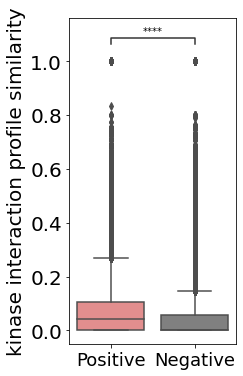

In [847]:
PPI_results_pos=combined_cancer_pos.PPI.tolist()
PPI_results_neg=combined_cancer_neg.PPI.tolist()
df=pd.DataFrame({'Jaccard Index':np.append(np.array(PPI_results_pos),np.array(PPI_results_neg)),
                 'Label':np.append(np.repeat('Positive',len(PPI_results_pos)),
                                   np.repeat('Negative',len(PPI_results_neg)))})
plt.figure(figsize=(3, 6))
x='Label'
y='Jaccard Index'
ax = sns.boxplot(data=df,x=x,y=y,palette=['lightcoral','grey'])
add_stat_annotation(ax, data=df, x=x, y=y,
                    box_pairs=[(('Positive','Negative'))],
                    test='t-test_ind', text_format='star', loc='inside', verbose=2)
plt.xticks(size=18)
plt.yticks(size=20)
plt.xlabel('')
plt.ylabel('kinase interaction profile similarity',size=20)
plt.savefig(''.join(['CoPheeMap/figures/kin_profile_pos.jpeg']),bbox_inches='tight',dpi=300,pad_inches=0.1,optimize=True,orientation='portrait')
plt.show()

In [637]:
idx=[]
for i in range(len(combined_cancer_pos)):
    name1=list(combined_cancer_pos.index[i])[0]
    name2=list(combined_cancer_pos.index[i])[1]
    idx.append('*'.join([name1,name2]))
combined_cancer_pos.index=idx

#idx=[]
#for i in range(len(combined_cancer_neg)):
#    name1=list(combined_cancer_neg.index[i])[0]
#    name2=list(combined_cancer_neg.index[i])[1]
#    idx.append('*'.join([name1,name2]))
#combined_cancer_neg.index=idx

In [638]:
site1=[k.split('*')[0] for k in combined_cancer_pos.index]
site2=[k.split('*')[1] for k in combined_cancer_pos.index]

In [639]:
#S/T-S/T Y-Y
site1=[k.split('*')[0] for k in combined_cancer_pos.index]
site2=[k.split('*')[1] for k in combined_cancer_pos.index]
aa1=[k.split('|')[2][0] for k in site1]
aa2=[k.split('|')[2][0] for k in site2]
label=[]
index=[]
for i in range(len(aa1)):
    if (aa1[i] in ['S','T']) and aa2[i] in ['S','T']:
        label.append(1)
        index.append(i)
    if (aa1[i] in ['Y']) and aa2[i] in ['Y']:
        label.append(0)
        index.append(i)
combined_cancer_pos=combined_cancer_pos.iloc[index]
combined_cancer_pos['STY']=np.array(label)

#site1=[k.split('*')[0] for k in combined_cancer_neg.index]
#site2=[k.split('*')[1] for k in combined_cancer_neg.index]
#aa1=[k.split('|')[2][0] for k in site1]
#aa2=[k.split('|')[2][0] for k in site2]
#label=[]
#index=[]
#for i in range(len(aa1)):
#    if (aa1[i] in ['S','T']) and aa2[i] in ['S','T']:
#        label.append(1)
#        index.append(i)
#    if (aa1[i] in ['Y']) and aa2[i] in ['Y']:
#        label.append(0)
#        index.append(i)
#combined_cancer_neg=combined_cancer_neg.iloc[index]
#combined_cancer_neg['STY']=np.array(label)

In [640]:
len(combined_cancer_pos)

12417

In [641]:
#combined_cancer_pos.to_csv('CoPheeMap/data_construction/gold_standard_site_pairs/combined_cancer_pos_balanced.csv')
#combined_cancer_neg.to_csv('CoPheeMap/data_construction/gold_standard_site_pairs/combined_cancer_neg.csv')

In [18]:
combined_cancer_pos=pd.read_csv('CoPheeMap/data_construction/gold_standard_site_pairs/combined_cancer_pos.csv',index_col=0)
combined_cancer_neg=pd.read_csv('CoPheeMap/data_construction/gold_standard_site_pairs/combined_cancer_neg.csv',index_col=0)

In [693]:
len(combined_cancer_pos)

161832

In [694]:
len(combined_cancer_neg)

1306973

Construction of training, testing and validation data
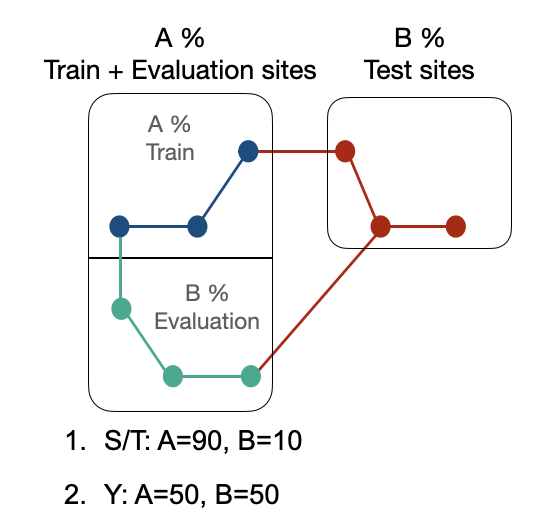

In [6]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn import tree
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import GridSearchCV,ParameterGrid
import random

In [696]:
combined_cancer_pos['Site1']=np.array([k.split('*')[0] for k in combined_cancer_pos.index])
combined_cancer_pos['Site2']=np.array([k.split('*')[1] for k in combined_cancer_pos.index])
combined_cancer_neg['Site1']=np.array([k.split('*')[0] for k in combined_cancer_neg.index])
combined_cancer_neg['Site2']=np.array([k.split('*')[1] for k in combined_cancer_neg.index])

In [717]:
#Hyperparameter tuning
#Preparation
pos_train_num=[]
pos_test_num=[]
Y_prediction=[]
Y_test=[]
neg_test_num=[]

data_pos=combined_cancer_pos
data_neg=combined_cancer_neg

data_neg=data_neg[(data_pos.columns)]
data_neg=data_neg.drop(['Site1','Site2'],axis=1)

#Shuffle the negatives
data_neg=data_neg.sample(frac=1)
data_pos_ST=data_pos[data_pos['STY']==1]
data_pos_Y=data_pos[data_pos['STY']==0]
data_neg_ST=data_neg[data_neg['STY']==1]
data_neg_Y=data_neg[data_neg['STY']==0]

s1=random.sample(list(set(data_pos_ST.Site1).union(set(data_pos_ST.Site2))),int(0.9*len(set(data_pos_ST.Site1).union(set(data_pos_ST.Site2)))))
s2=[i for i in list(set(data_pos_ST.Site1).union(set(data_pos_ST.Site2))) if i not in s1]
s3=random.sample(list(set(data_pos_Y.Site1).union(set(data_pos_Y.Site2))),int(0.5*len(set(data_pos_Y.Site1).union(set(data_pos_Y.Site2)))))
s4=[i for i in list(set(data_pos_Y.Site1).union(set(data_pos_Y.Site2))) if i not in s3]

index_train=[]
index_test=[]
for i in range(len(data_pos)):
    if (data_pos.Site1.iloc[i] in s1) and (data_pos.Site2.iloc[i] in s1):
        index_train.append(i)
    if (data_pos.Site1.iloc[i] in s3) and (data_pos.Site2.iloc[i] in s3):
        index_train.append(i)
    if (data_pos.Site1.iloc[i] in s2) and (data_pos.Site2.iloc[i] in s2):
        index_test.append(i)
    if (data_pos.Site1.iloc[i] in s1) and (data_pos.Site2.iloc[i] in s2):
        index_test.append(i)
    if (data_pos.Site1.iloc[i] in s2) and (data_pos.Site2.iloc[i] in s1):
        index_test.append(i)
    if (data_pos.Site1.iloc[i] in s4) and (data_pos.Site2.iloc[i] in s4):
        index_test.append(i)
    if (data_pos.Site1.iloc[i] in s3) and (data_pos.Site2.iloc[i] in s4):
        index_test.append(i)
    if (data_pos.Site1.iloc[i] in s4) and (data_pos.Site2.iloc[i] in s3):
        index_test.append(i)
pos_train_num.append(len(index_train))
pos_test_num.append(len(index_test))
data_pos_train=data_pos.iloc[index_train]
data_pos_test=data_pos.iloc[index_test]
data_pos_test=data_pos_test.drop(['Site1','Site2'],axis=1)
idx_train=random.sample(data_neg_Y.index.tolist(),300)
idx_train_eval=random.sample(idx_train,79)
idx_test=[i for i in data_neg_Y.index.tolist() if i not in idx_train]
idx_train=[i for i in idx_train if i not in idx_train_eval]

data_neg_Y_train=data_neg_Y[data_neg_Y.index.isin(idx_train)]
data_neg_Y_train_eval=data_neg_Y[data_neg_Y.index.isin(idx_train_eval)]
data_neg_Y_test=data_neg_Y[data_neg_Y.index.isin(idx_test)]
data_neg_Y_test=data_neg_Y_test.sample(frac=1)

data_pos_train_ST=data_pos_train[data_pos_train['STY']==1]
data_pos_train_Y=data_pos_train[data_pos_train['STY']==0]

Construction of CoPheeMap

Features for CoPheeMap: 1)Sequence similarities; 2)Kinase interaction profile similarities 3) Phosphosite correlations

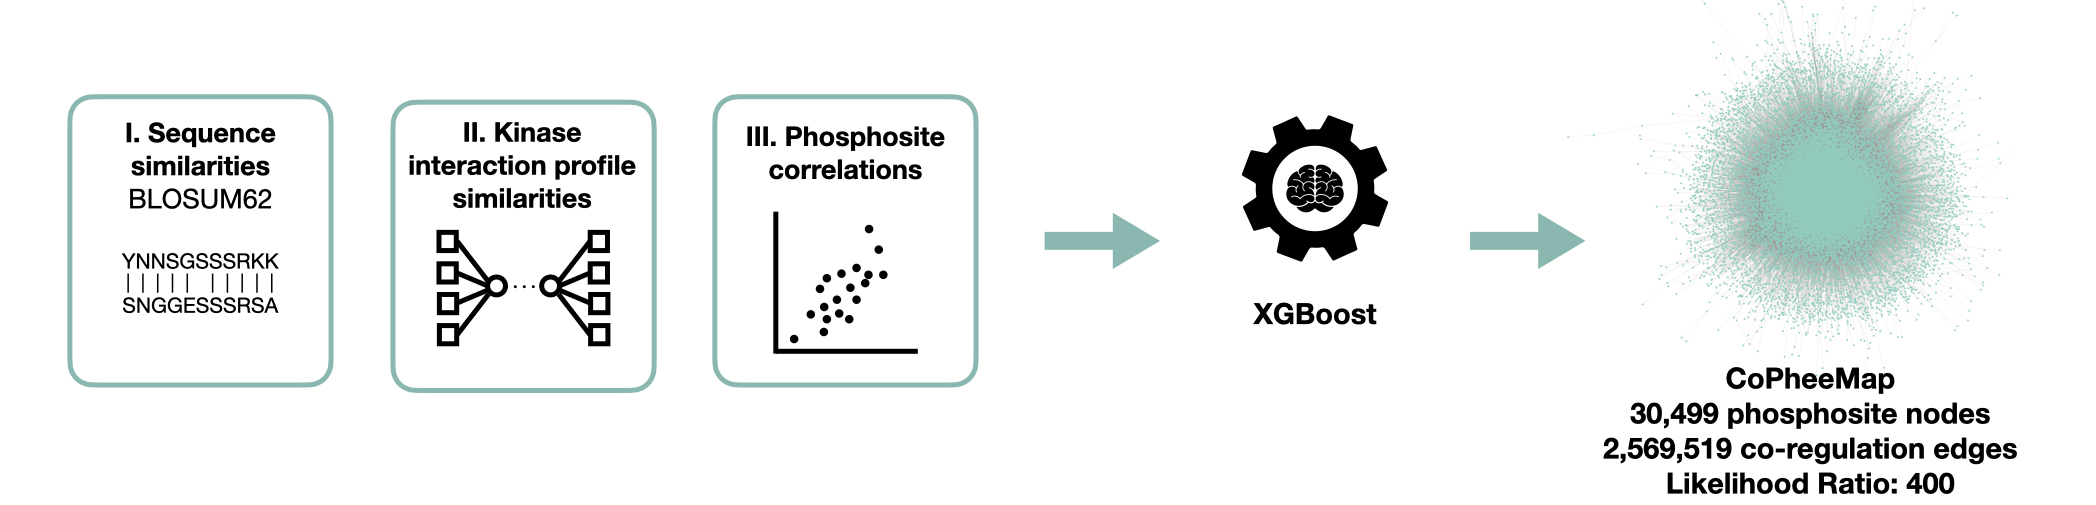

In [648]:
#XGBoost
#Hyperparameter tuning
#1:5 Imbalanced Positve:Negative
params = { 'max_depth': [3,4,5,6,7,8],
           'learning_rate': [0.05,0.1,0.15,0.2],
          'objective': ['binary:logistic'],
          'nthread':[8],
           'eval_metric':['aucpr']}
auprc_result=[]
auroc_result=[]
for p in ParameterGrid(params):
    auc_precision_recall=[]
    auc_curve=[]
    for n in range(5):
        s1=random.sample(list(set(data_pos_train_ST.Site1).union(set(data_pos_train_ST.Site2))),int(0.9*len(set(data_pos_train_ST.Site1).union(set(data_pos_train_ST.Site2)))))
        s2=[i for i in list(set(data_pos_train_ST.Site1).union(set(data_pos_train_ST.Site2))) if i not in s1]
        s3=random.sample(list(set(data_pos_train_Y.Site1).union(set(data_pos_train_Y.Site2))),int(0.5*len(set(data_pos_train_Y.Site1).union(set(data_pos_train_Y.Site2)))))
        s4=[i for i in list(set(data_pos_train_Y.Site1).union(set(data_pos_train_Y.Site2))) if i not in s3]
        index_train=[]
        index_test=[]
        for i in range(len(data_pos_train)):
            if (data_pos_train.Site1.iloc[i] in s1) and (data_pos_train.Site2.iloc[i] in s1):
                index_train.append(i)
            if (data_pos_train.Site1.iloc[i] in s2) and (data_pos_train.Site2.iloc[i] in s2):
                index_test.append(i)
            if (data_pos_train.Site1.iloc[i] in s1) and (data_pos_train.Site2.iloc[i] in s2):
                index_test.append(i)
            if (data_pos_train.Site1.iloc[i] in s2) and (data_pos_train.Site2.iloc[i] in s1):
                index_test.append(i)
            if (data_pos_train.Site1.iloc[i] in s3) and (data_pos_train.Site2.iloc[i] in s3):
                index_train.append(i)
            if (data_pos_train.Site1.iloc[i] in s4) and (data_pos_train.Site2.iloc[i] in s4):
                index_test.append(i)
            if (data_pos_train.Site1.iloc[i] in s3) and (data_pos_train.Site2.iloc[i] in s4):
                index_test.append(i)
            if (data_pos_train.Site1.iloc[i] in s4) and (data_pos_train.Site2.iloc[i] in s3):
                index_test.append(i)

        data_pos_train_train=data_pos_train.iloc[index_train]
        data_pos_train_eval=data_pos_train.iloc[index_test]
        data_pos_train_train=data_pos_train_train.drop(['Site1','Site2'],axis=1)
        data_pos_train_eval=data_pos_train_eval.drop(['Site1','Site2'],axis=1)

        X_train = pd.concat([data_pos_train_train.iloc[:,:],data_neg_ST.iloc[0:5*len(data_pos_train_train),:]])
        X_train = pd.concat([X_train,data_neg_Y_train])

        X_train_eval = pd.concat([data_pos_train_eval.iloc[:,:],data_neg_ST.iloc[5*len(data_pos_train_train):5*len(data_pos_train_train)+5*len(data_pos_train_eval),:]])
        X_train_eval = pd.concat([X_train_eval,data_neg_Y_train_eval])

        y_train = np.concatenate((np.repeat(1,len(data_pos_train_train)),np.repeat(0,len(X_train)-len(data_pos_train_train))))
        y_train_eval = np.concatenate((np.repeat(1,len(data_pos_train_eval)),np.repeat(0,len(X_train_eval)-len(data_pos_train_eval))))


        dtrain_train = xgb.DMatrix(X_train, label=y_train)
        dtrain_eval = xgb.DMatrix(X_train_eval, label=y_train_eval)


        evallist = [(dtrain_train, 'train') , (dtrain_eval, 'eval')]
        num_round = 200
        bst = xgb.train(p, dtrain_train, num_round, evallist,verbose_eval=False,early_stopping_rounds=10)
        y_pred = bst.predict(dtrain_eval)
        precision, recall, thresholds = metrics.precision_recall_curve(y_train_eval, y_pred)
        auc_precision_recall.append(auc(recall, precision))
        fpr, tpr, thresholds = metrics.roc_curve(y_train_eval, y_pred)
        auc_curve.append(auc(fpr, tpr))
    auprc_result.append(auc_precision_recall)
    auroc_result.append(auc_curve)


/var/folders/2k/p13z68bx7p9fvh4xn3mbjn_r0000gr/T/ipykernel_84213/3554159551.py:25: MatplotlibDeprecationWarning: 
The 'optimize' parameter of print_jpg() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use pil_kwargs={'optimize': ...} instead. If any parameter follows 'optimize', they should be passed as keyword, not positionally.
  plt.savefig(''.join(['CoPheeMap/figures/hyperpara_balanced_pos','.jpeg']),bbox_inches='tight',dpi=300,pad_inches=0.1,optimize=True,orientation='portrait')


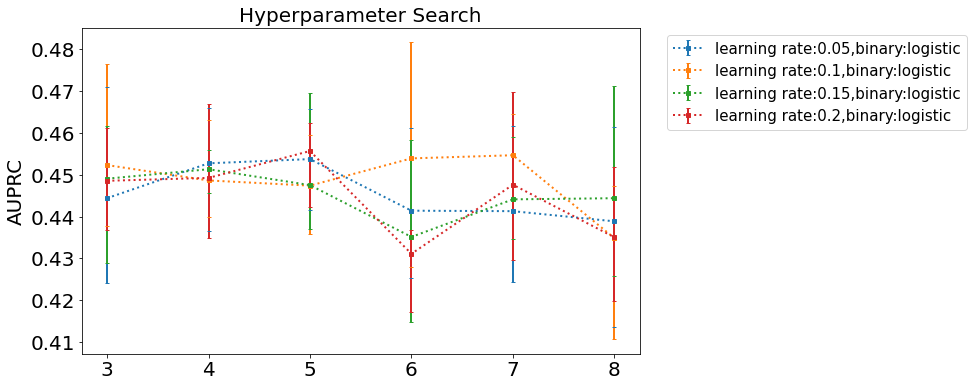

In [649]:
plt.figure(1, figsize=(10,6))
pallete = sns.color_palette()
result=auprc_result
#result=auroc_result
ls=[':','--','-']
for i in range(4):
    num=range(6*i,6*i+6,1)
    auprc_min=[min(result[i]) for i in num]
    auprc_max=[max(result[i]) for i in num]
    auprc_min_max = np.array(list(zip(auprc_min,auprc_max))).T
    auprc_err = np.abs(auprc_min_max - [np.mean(result[i]) for i in num])
    plt.errorbar(['3','4','5','6','7','8'], [np.mean(result[i]) for i in num], yerr=auprc_err, marker='s', capsize=2,
                 color=pallete[i], markersize=4, linewidth=2, linestyle=':')
    
plt.xticks(size=20)
plt.yticks(size=20)
#plt.ylabel('AUROC',size=20)
plt.ylabel('AUPRC',size=20)
#plt.xlabel('Max_depth',size=14)
plt.legend(['learning rate:0.05,binary:logistic',
            'learning rate:0.1,binary:logistic',
            'learning rate:0.15,binary:logistic',
            'learning rate:0.2,binary:logistic'],bbox_to_anchor=(1.6, 1),fontsize=15)
plt.title("Hyperparameter Search",size=20)
plt.savefig(''.join(['CoPheeMap/figures/all_pos_hyperpara','.jpeg']),bbox_inches='tight',dpi=300,pad_inches=0.1,optimize=True,orientation='portrait')
plt.show()

In [783]:
#1:5
params = { 'max_depth': [4],
           'learning_rate': [0.15],
          'objective': ['binary:logistic'],
          'nthread':[8],
           'eval_metric':['aucpr']}
auprc_result=[]
auroc_result=[]
mean_fpr = np.linspace(0, 1, 100)
for p in ParameterGrid(params):
    
    auc_precision_recall=[]
    auc_curve=[]
    fprs_forplot=[]
    tprs_forplot=[]
    tprs=[]
    aucs=[]
    auc_curve_static=[]
    fprs_forplot_static=[]
    tprs_forplot_static=[]
    tprs_static=[]
    aucs_static=[]
    
    auc_curve_dynamic=[]
    fprs_forplot_dynamic=[]
    tprs_forplot_dynamic=[]
    tprs_dynamic=[]
    aucs_dynamic=[]
    for n in range(1):
        s1=random.sample(list(set(data_pos_train_ST.Site1).union(set(data_pos_train_ST.Site2))),int(0.9*len(set(data_pos_train_ST.Site1).union(set(data_pos_train_ST.Site2)))))
        s2=[i for i in list(set(data_pos_train_ST.Site1).union(set(data_pos_train_ST.Site2))) if i not in s1]
        s3=random.sample(list(set(data_pos_train_Y.Site1).union(set(data_pos_train_Y.Site2))),int(0.5*len(set(data_pos_train_Y.Site1).union(set(data_pos_train_Y.Site2)))))
        s4=[i for i in list(set(data_pos_train_Y.Site1).union(set(data_pos_train_Y.Site2))) if i not in s3]
        index_train=[]
        index_test=[]
        for i in range(len(data_pos_train)):
            if (data_pos_train.Site1.iloc[i] in s1) and (data_pos_train.Site2.iloc[i] in s1):
                index_train.append(i)
            if (data_pos_train.Site1.iloc[i] in s2) and (data_pos_train.Site2.iloc[i] in s2):
                index_test.append(i)
            if (data_pos_train.Site1.iloc[i] in s1) and (data_pos_train.Site2.iloc[i] in s2):
                index_test.append(i)
            if (data_pos_train.Site1.iloc[i] in s2) and (data_pos_train.Site2.iloc[i] in s1):
                index_test.append(i)
            if (data_pos_train.Site1.iloc[i] in s3) and (data_pos_train.Site2.iloc[i] in s3):
                index_train.append(i)
            if (data_pos_train.Site1.iloc[i] in s4) and (data_pos_train.Site2.iloc[i] in s4):
                index_test.append(i)
            if (data_pos_train.Site1.iloc[i] in s3) and (data_pos_train.Site2.iloc[i] in s4):
                index_test.append(i)
            if (data_pos_train.Site1.iloc[i] in s4) and (data_pos_train.Site2.iloc[i] in s3):
                index_test.append(i)

        data_pos_train_train=data_pos_train.iloc[index_train]
        data_pos_train_eval=data_pos_train.iloc[index_test]
        data_pos_train_train=data_pos_train_train.drop(['Site1','Site2'],axis=1)
        data_pos_train_eval=data_pos_train_eval.drop(['Site1','Site2'],axis=1)

        X_train = pd.concat([data_pos_train_train.iloc[:,:],data_neg_ST.iloc[0:5*len(data_pos_train_train),:]])
        X_train = pd.concat([X_train,data_neg_Y_train])
        X_train=X_train.iloc[:,0:]
        X_train_static=X_train[['seq_simi', 'PPI', 'STY']]
        X_train_dynamic=X_train.iloc[:,0:11]


        X_train_eval = pd.concat([data_pos_train_eval.iloc[:,:],data_neg_ST.iloc[5*len(data_pos_train_train):5*len(data_pos_train_train)+5*len(data_pos_train_eval),:]])
        X_train_eval = pd.concat([X_train_eval,data_neg_Y_train_eval])
        X_train_eval=X_train_eval.iloc[:,0:]
        X_train_static_eval=X_train_eval[['seq_simi', 'PPI', 'STY']]
        X_train_dynamic_eval=X_train_eval.iloc[:,0:11]

        X_test = pd.concat([data_pos_test.iloc[:,:],data_neg_ST.iloc[5*len(data_pos_train_train)+5*len(data_pos_train_eval):5*len(data_pos_train_train)+5*len(data_pos_train_eval)+50*len(data_pos_test),:]])
        X_test = pd.concat([X_test,data_neg_Y_test])
        pairs_site=X_test.index.tolist()
        X_test=X_test.iloc[:,0:]
        X_test_static=X_test[['seq_simi', 'PPI', 'STY']]
        X_test_dynamic=X_test.iloc[:,0:11]

        y_train = np.concatenate((np.repeat(1,len(data_pos_train_train)),np.repeat(0,len(X_train)-len(data_pos_train_train))))
        y_train_eval = np.concatenate((np.repeat(1,len(data_pos_train_eval)),np.repeat(0,len(X_train_eval)-len(data_pos_train_eval))))
        y_test = np.concatenate((np.repeat(1,len(data_pos_test)),np.repeat(0,len(X_test)-len(data_pos_test))))

        
        dtrain_train = xgb.DMatrix(X_train, label=y_train)
        dtrain_eval = xgb.DMatrix(X_train_eval, label=y_train_eval)
        dtest = xgb.DMatrix(X_test, label=y_test)
        
        dtrain_train_static = xgb.DMatrix(X_train_static, label=y_train)
        dtrain_eval_static = xgb.DMatrix(X_train_static_eval, label=y_train_eval)
        dtest_static = xgb.DMatrix(X_test_static, label=y_test)
        
        dtrain_train_dynamic = xgb.DMatrix(X_train_dynamic, label=y_train)
        dtrain_eval_dynamic = xgb.DMatrix(X_train_dynamic_eval, label=y_train_eval)
        dtest_dynamic = xgb.DMatrix(X_test_dynamic, label=y_test)

        evallist = [(dtrain_train, 'train'),(dtrain_eval, 'eval')]
        num_round = 200
        bst = xgb.train(p, dtrain_train, num_round, evallist,verbose_eval=False,early_stopping_rounds=10)
        bst.save_model('CoPheeMap/model/imbalanced_pos_xgboost.json')
        y_pred = bst.predict(dtest)

        fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
        auc_curve.append(auc(fpr, tpr))
        fprs_forplot.append(fpr)
        tprs_forplot.append(tpr)
        tprs.append(np.interp(mean_fpr, fpr, tpr))
        aucs.append(auc(fpr, tpr))
        
        evallist = [(dtrain_train_static, 'train'),(dtrain_eval_static, 'eval')]
        num_round = 200
        bst = xgb.train(p, dtrain_train_static, num_round, evallist,verbose_eval=False,early_stopping_rounds=10)
        y_pred_static = bst.predict(dtest_static)

        fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_static)
        auc_curve_static.append(auc(fpr, tpr))
        fprs_forplot_static.append(fpr)
        tprs_forplot_static.append(tpr)
        tprs_static.append(np.interp(mean_fpr, fpr, tpr))
        aucs_static.append(auc(fpr, tpr))
        
        
        evallist = [(dtrain_train_dynamic, 'train'),(dtrain_eval_dynamic, 'eval')]
        num_round = 200
        bst = xgb.train(p, dtrain_train_dynamic, num_round, evallist,verbose_eval=False,early_stopping_rounds=10)
        y_pred_dynamic = bst.predict(dtest_dynamic)

        fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_dynamic)
        auc_curve_dynamic.append(auc(fpr, tpr))
        fprs_forplot_dynamic.append(fpr)
        tprs_forplot_dynamic.append(tpr)
        tprs_dynamic.append(np.interp(mean_fpr, fpr, tpr))
        aucs_dynamic.append(auc(fpr, tpr))

    auprc_result.append(auc_precision_recall)
    auroc_result.append(auc_curve)

X_test.index=pairs_site
X_test.to_csv('CoPheeMap/model/imbalanced_pos_Ground_truth_test.csv',index=True)
pd.DataFrame(y_test).to_csv('CoPheeMap/model/imbalanced_pos_Ground_truth_test_label.csv')

/var/folders/2k/p13z68bx7p9fvh4xn3mbjn_r0000gr/T/ipykernel_84213/6401444.py:58: MatplotlibDeprecationWarning: 
The 'optimize' parameter of print_jpg() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use pil_kwargs={'optimize': ...} instead. If any parameter follows 'optimize', they should be passed as keyword, not positionally.
  plt.savefig(''.join(['CoPheeMap/figures/AUROC_allpos.jpeg']),bbox_inches='tight',dpi=300,pad_inches=0.1,optimize=True,orientation='portrait')


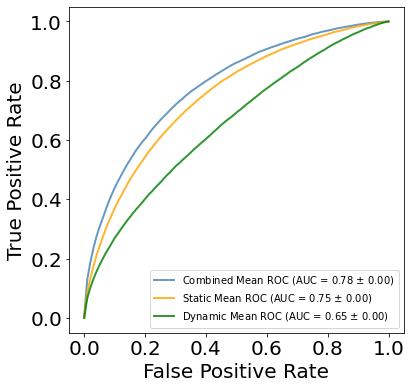

In [784]:
plt.figure(1, figsize=(6,6))
for i in range(len(auc_curve)):
    plt.plot(fprs_forplot[i], tprs_forplot[i], color='steelblue', linewidth=1, alpha=0.10, label=None)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)

plt.plot(mean_fpr, mean_tpr, color='steelblue',
         label=r'Combined Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         linewidth=2.0, alpha=0.80)
std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)



mean_tpr = np.mean(tprs_static, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs_static)

for i in range(len(aucs)):
    plt.plot(fprs_forplot_static[i], tprs_forplot_static[i], color='orange', linewidth=1, alpha=0.10, label=None)


plt.plot(mean_fpr, mean_tpr, color='orange',
         label=r'Static Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         linewidth=2.0, alpha=0.80)
std_tpr = np.std(tprs_static, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)


mean_tpr = np.mean(tprs_dynamic, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs_dynamic)

for i in range(len(aucs)):
    plt.plot(fprs_forplot_dynamic[i], tprs_forplot_dynamic[i], color='green', linewidth=1, alpha=0.10, label=None)


plt.plot(mean_fpr, mean_tpr, color='green',
         label=r'Dynamic Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         linewidth=2.0, alpha=0.80)
std_tpr = np.std(tprs_static, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)


plt.legend(loc="lower right",fontsize=10)
plt.xticks(size=20)
plt.yticks(size=20)
plt.xlabel('False Positive Rate',size=20)
plt.ylabel('True Positive Rate',size=20)
plt.savefig(''.join(['CoPheeMap/figures/AUROC_allpos.jpeg']),bbox_inches='tight',dpi=300,pad_inches=0.1,optimize=True,orientation='portrait')
plt.show()

In [4]:
bst = xgb.Booster()
bst.load_model("CoPheeMap/model/imbalanced_pos_xgboost.json")
X_test=pd.read_csv('CoPheeMap/model/imbalanced_pos_Ground_truth_test.csv',index_col=0)
y_test=pd.read_csv('CoPheeMap/model/imbalanced_pos_Ground_truth_test_label.csv',index_col=0)

In [5]:
dtest = xgb.DMatrix(X_test, label=y_test)
y_pred = bst.predict(dtest)

In [6]:
#FPR
#Threshold with FPR < 0.02
tmp={}
tmp['score']=y_pred
tmp['label']=y_test.iloc[:,0].values
tmp['pairs']=np.array(X_test.index.tolist())
tmp_test=pd.DataFrame(tmp)
tmp_test=tmp_test.sort_values(['score'],ascending=False)
threds=tmp_test.score.tolist()
FPR=[]
for i in threds[:1000]:
    test_pos=tmp_test[tmp_test['score']>=i]
    num_pos=len(test_pos[test_pos.label==1])
    num_neg=len(test_pos[test_pos.label==0])
    FPR.append(round(num_neg/(num_pos+num_neg),10))

In [7]:
df_FPR=pd.DataFrame()
df_FPR['FPR']=FPR
df_FPR['threshold']=threds[:1000]

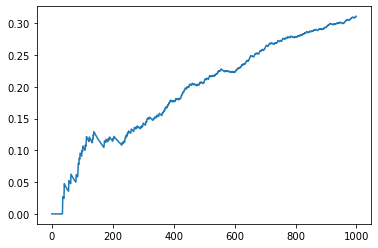

In [8]:
plt.plot(FPR)

In [803]:
tmp=df_FPR[df_FPR.FPR<0.02]
threshold=tmp.threshold.iloc[-1]

In [804]:
threshold

0.9679405093193054

Prediction data preparation
Correlations (PCCs) between phosphosites: at least 20 samples quantified for both sites

In [25]:
from os import listdir
from os.path import isfile, join

In [ ]:
threshold=0.9679405093193054

In [ ]:
#Prediction
mypath=''.join(['CoPheeMap/data_construction/prediction_data/'])
onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]
onlyfiles=[i for i in onlyfiles if i[0]!='.']

for i in range(len(onlyfiles)):
    print(i)
    file_label=str(i)
    pred_test=pd.read_csv('/'.join([mypath,onlyfiles[i]]),index_col=0)
    IDX=pred_test.index.tolist()
    y_label=np.repeat(0,len(pred_test))
    dpred_test = xgb.DMatrix(pred_test, label=y_label)
    y_pred_test = bst.predict(dpred_test)
    tmp={}
    tmp['score']=y_pred_test
    del y_pred_test, dpred_test, pred_test, y_label
    tmp=pd.DataFrame(tmp)
    data=tmp
    data.index=IDX
    data.to_csv('CoPheeMap/data_construction/model_all_pos/prediction_results/pred_'+file_label+'.csv',index=True)
   

In [806]:
#Predicted positives
mypath=''.join(['CoPheeMap/data_construction/model_all_pos/prediction_results/'])
onlyfiles2 = [f for f in listdir(mypath) if isfile(join(mypath, f))]
onlyfiles2=[i for i in onlyfiles2 if i[0]!='.']
DATA=pd.DataFrame()
total_pos=0
for i in range(len(onlyfiles2)):
    data=pd.read_csv('/'.join([mypath,onlyfiles2[i]]),index_col=0)
    total_pos=total_pos+len(data)
    data=data[data['score']>=threshold]
    DATA=pd.concat([DATA,data])
#DATA.to_csv('CoPheeMap/data_construction/model_all_pos/predicted_positives.csv',index=True)

0.9679405093193054


In [ ]:
#Positive data
mypath=''.join(['CoPheeMap/data_construction/prediction_data/'])
onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]
onlyfiles=[i for i in onlyfiles if i[0]!='.']
tmp=pd.DataFrame()
for i in range(len(onlyfiles)):
    file_label=str(i)
    print(i)
    pred_test=pd.read_csv('/'.join([mypath,onlyfiles[i]]),index_col=0)

    y_label=np.repeat(0,len(pred_test))
    dpred_test = xgb.DMatrix(pred_test, label=y_label)
    y_pred_test = bst.predict(dpred_test)
    pred_test['score']=y_pred_test
    pred_test=pred_test[pred_test['score']>=threshold]
    tmp=pd.concat([tmp,pred_test])

#tmp.to_csv('CoPheeMap/data_construction/model_all_pos/positive_data/pos_data.csv',index=True)

In [808]:
def get_key(val):
    for key, value in All_sites.items():
         if val == value:
                return key
    return "key doesn't exist"

In [809]:
site1=[k.split(',')[0][1:] for k in DATA.index.tolist()]
site2=[k.split(',')[1][1:-1] for k in DATA.index.tolist()]
site1_new=[]
site2_new=[]
for i in range(len(site1)):
    site1_new.append(get_key(int(site1[i])))
    site2_new.append(get_key(int(site2[i])))
df=pd.DataFrame()
df['site1']=np.array(site1_new)
df['site2']=np.array(site2_new)
print(len(set(site1_new+site2_new)))
#df.to_csv('CoPheeMap/data_construction/model_all_pos/All_positive_thred_9679.csv',index=0)

26280


In [51]:
#PCC
data=pd.read_csv('CoPheeMap/data_construction/model_all_pos/positive_data/pos_data.csv',index_col=0)

In [811]:
PCC1=np.array([])
tumor1=np.array([])
for i in range(0,11):
    PCC1=np.append(PCC1,data.iloc[:,i].values)
    tumor1=np.append(tumor1, np.repeat(Names[i],len(data)))
label1=np.repeat('CoPheeMap sites',len(PCC1))

PCC2=np.array([])
tumor2=np.array([])
for i in range(0,11):
    PCC2=np.append(PCC2,results_pos[i].PCC.values)
    tumor2=np.append(tumor2, np.repeat(Names[i],len(results_pos[i])))
label2=np.repeat('Positive',len(PCC2))
df={'PCC':np.append(PCC1,PCC2),'tumor':np.append(tumor1,tumor2),
    'label':np.append(label1,label2)}
df=pd.DataFrame(df)

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

PDAC_CoPheeMap sites v.s. PDAC_Positive: t-test independent samples with Bonferroni correction, P_val=0.000e+00 stat=9.654e+01
UCEC_CoPheeMap sites v.s. UCEC_Positive: t-test independent samples with Bonferroni correction, P_val=0.000e+00 stat=1.513e+02
OV_CoPheeMap sites v.s. OV_Positive: t-test independent samples with Bonferroni correction, P_val=0.000e+00 stat=4.399e+01
CCRCC_CoPheeMap sites v.s. CCRCC_Positive: t-test independent samples with Bonferroni correction, P_val=0.000e+00 stat=7.398e+01
BRCA_CoPheeMap sites v.s. BRCA_Positive: t-test independent samples with Bonferroni correction, P_val=0.000e+00 stat=8.322e+01
COAD_CoPheeMap sites v.s. COAD_Positive: t-test independent samples with Bonferroni correction, P_val=0.000e+00 stat=7.993e+01
GBM_CoPheeMap sites v.s. GBM_Positive: t-test independent samples with Bonfe

/var/folders/2k/p13z68bx7p9fvh4xn3mbjn_r0000gr/T/ipykernel_84213/1500975644.py:25: MatplotlibDeprecationWarning: 
The 'optimize' parameter of print_jpg() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use pil_kwargs={'optimize': ...} instead. If any parameter follows 'optimize', they should be passed as keyword, not positionally.
  plt.savefig('CoPheeMap/figures/PCC_tumor_predictpos_allpos.jpeg',bbox_inches='tight',dpi=300,pad_inches=0.1,optimize=True,orientation='portrait')


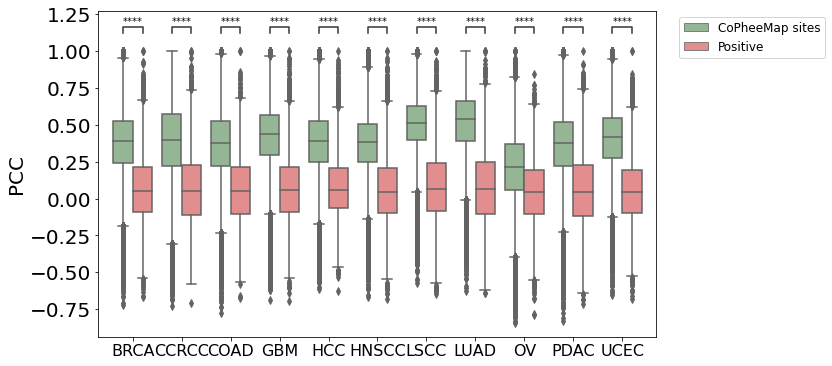

In [812]:
plt.figure(figsize=(10, 6))
x = "tumor"
y = "PCC"
hue = "label"
ax = sns.boxplot(data=df, x=x, y=y, hue=hue, palette=['darkseagreen','lightcoral'])
add_stat_annotation(ax, data=df, x=x, y=y, hue=hue,
                    box_pairs=[(("BRCA", "CoPheeMap sites"), ("BRCA", "Positive")),
                                 (("CCRCC", "CoPheeMap sites"), ("CCRCC", "Positive")),
                                 (("COAD", "CoPheeMap sites"), ("COAD", "Positive")),
                                 (("GBM", "CoPheeMap sites"), ("GBM", "Positive")),
                                 (("HCC", "CoPheeMap sites"), ("HCC", "Positive")),
                                 (("HNSCC", "CoPheeMap sites"), ("HNSCC", "Positive")),
                                 (("LSCC", "CoPheeMap sites"), ("LSCC", "Positive")),
                                 (("LUAD", "CoPheeMap sites"), ("LUAD", "Positive")),
                                 (("OV", "CoPheeMap sites"), ("OV", "Positive")),
                                 (("PDAC", "CoPheeMap sites"), ("PDAC", "Positive")),
                                 (("UCEC", "CoPheeMap sites"), ("UCEC", "Positive"))
                                ],
                    test='t-test_ind', text_format='star', loc='inside', verbose=2)
plt.xticks(size=16)
plt.yticks(size=20)
plt.xlabel('')
plt.ylabel('PCC',size=20)
plt.legend(loc='upper left', bbox_to_anchor=(1.03, 1),fontsize=12)
plt.savefig('CoPheeMap/figures/PCC_tumor_predictpos_allpos.jpeg',bbox_inches='tight',dpi=300,pad_inches=0.1,optimize=True,orientation='portrait')
plt.show()

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

CoPheeMap sites v.s. Positive: t-test independent samples with Bonferroni correction, P_val=0.000e+00 stat=2.021e+02


/var/folders/2k/p13z68bx7p9fvh4xn3mbjn_r0000gr/T/ipykernel_84213/58680149.py:19: MatplotlibDeprecationWarning: 
The 'optimize' parameter of print_jpg() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use pil_kwargs={'optimize': ...} instead. If any parameter follows 'optimize', they should be passed as keyword, not positionally.
  plt.savefig('CoPheeMap/figures/seq_similarity_predpos_allpos.jpeg',bbox_inches='tight',dpi=300,pad_inches=0.1,optimize=True,orientation='portrait')


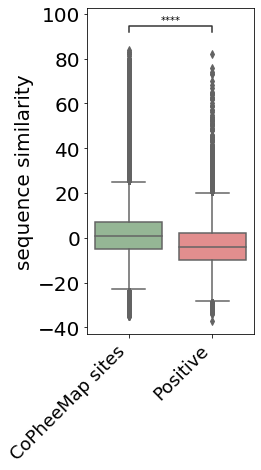

In [813]:
#Sequence similarity
simi_neg=combined_cancer_pos.seq_simi.tolist()
simi_pos=data.seq_simi.tolist()
df=pd.DataFrame({'Similarity':np.append(np.array(simi_pos),np.array(simi_neg)),
                 'Label':np.append(np.repeat('CoPheeMap sites',len(simi_pos)),
                                   np.repeat('Positive',len(simi_neg)))})
plt.figure(figsize=(3, 6))
x='Label'
y='Similarity'
ax = sns.boxplot(data=df,x=x,y=y,palette=['darkseagreen','lightcoral'])
add_stat_annotation(ax, data=df, x=x, y=y,
                    box_pairs=[(('CoPheeMap sites','Positive'))],
                    test='t-test_ind', text_format='star', loc='inside', verbose=2)
plt.xticks(rotation=45,ha='right',size=18)
plt.yticks(size=20)
plt.xlabel('')
plt.ylabel('sequence similarity',size=20)
#plt.legend(loc='upper left', bbox_to_anchor=(1.03, 1),fontsize=12)
plt.savefig('CoPheeMap/figures/seq_similarity_predpos_allpos.jpeg',bbox_inches='tight',dpi=300,pad_inches=0.1,optimize=True,orientation='portrait')
plt.show()

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

CoPheeMap sites v.s. Positive: t-test independent samples with Bonferroni correction, P_val=9.120e-298 stat=3.691e+01


/var/folders/2k/p13z68bx7p9fvh4xn3mbjn_r0000gr/T/ipykernel_84213/277362734.py:19: MatplotlibDeprecationWarning: 
The 'optimize' parameter of print_jpg() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use pil_kwargs={'optimize': ...} instead. If any parameter follows 'optimize', they should be passed as keyword, not positionally.
  plt.savefig('CoPheeMap/figures/PPI_predpos_allpos.jpeg',bbox_inches='tight',dpi=300,pad_inches=0.1,optimize=True,orientation='portrait')


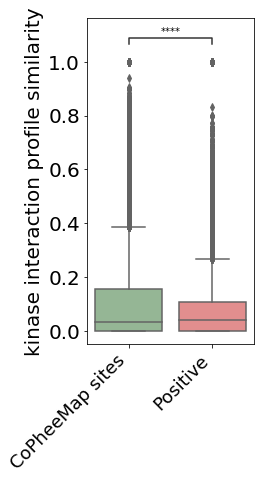

In [814]:
#kinase interaction profile similarity
simi_neg=combined_cancer_pos.PPI.tolist()
simi_pos=data.PPI.tolist()
df=pd.DataFrame({'PPI':np.append(np.array(simi_pos),np.array(simi_neg)),
                 'Label':np.append(np.repeat('CoPheeMap sites',len(simi_pos)),
                                   np.repeat('Positive',len(simi_neg)))})
plt.figure(figsize=(3, 6))
x='Label'
y='PPI'
ax = sns.boxplot(data=df,x=x,y=y,palette=['darkseagreen','lightcoral'])
add_stat_annotation(ax, data=df, x=x, y=y,
                    box_pairs=[(('CoPheeMap sites','Positive'))],
                    test='t-test_ind', text_format='star', loc='inside', verbose=2)
plt.xticks(rotation=45,ha='right',size=18)
plt.yticks(size=20)
plt.xlabel('')
plt.ylabel('kinase interaction profile similarity',size=20)
#plt.legend(loc='upper left', bbox_to_anchor=(1.03, 1),fontsize=12)
plt.savefig('CoPheeMap/figures/PPI_predpos_allpos.jpeg',bbox_inches='tight',dpi=300,pad_inches=0.1,optimize=True,orientation='portrait')
plt.show()

In [53]:
network=pd.read_csv('CoPheeMap/data_construction/model_all_pos/All_positive_thred_9679.csv',index_col=0)

In [816]:
sites=list(set(network.index.tolist()+network.site2.tolist()))
embl=[s.split('|')[0] for s in sites]
embl=[s.split('.')[0] for s in embl]
with open('CoPheeMap/data_construction/model_all_pos/all_sites_pro_in_network.csv', 'w') as fp:
    for item in embl:
        # write each item on a new line
        fp.write("%s\n" % item)
    print('Done')
sites_notin_network=[s for s in All_sites if s not in sites]
embl=[s.split('|')[0] for s in sites_notin_network]
embl=[s.split('.')[0] for s in embl]
with open('CoPheeMap/data_construction/model_all_pos/all_sites_pro_not_in_network.csv', 'w') as fp:
    for item in embl:
        # write each item on a new line
        fp.write("%s\n" % item)
    print('Done')

Done
Done


In [817]:
sites=pd.read_table('CoPheeMap/data_construction/model_all_pos/all_sites_pro_in_network.csv',header=None)
sites_notin_network=pd.read_table('CoPheeMap/data_construction/model_all_pos/all_sites_pro_not_in_network.csv',header=None)
sites=sites.drop_duplicates()
sites_notin_network=sites_notin_network.drop_duplicates()
sites_notin_network=sites_notin_network[~sites_notin_network[0].isna()]

In [818]:
#Functional scores
funsco=pd.read_excel('Funsco/41587_2019_344_MOESM5_ESM.xlsx')
mapping=pd.read_table('Funsco/uniprot-compressed_true_download_true_fields_accession_2Creviewed_2C-2022.08.03-16.36.34.17.tsv')
mapping=mapping[~mapping['Gene Names'].isna()]
names=mapping['Gene Names'].iloc[2].split('-')
uniprot=[]
embl=[]
gene_name=[]
for i in range(len(sites)):
    name=sites.iloc[i,1]
    for k in range(len(mapping)):
        if name in mapping['Gene Names'].iloc[k]:
            uniprot.append(mapping['From'].iloc[k])
            gene_name.append(name)
            embl.append(sites.iloc[i,0])
            break
df_sites=pd.DataFrame()
df_sites['protein']=np.array(embl)
df_sites['gene_name']=np.array(gene_name)
df_sites['uniprot']=np.array(uniprot)
Position=[]
AA=[]
protein=[]
gene_name=[]
uniprot=[]
sites=list(set(network.index.tolist()+network.site2.tolist()))
for s in sites:
    site=s.split('|')[2]
    pos=site[1:]
    aa=site[0]
    pro=s.split('|')[0]
    pro=pro.split('.')[0]
    if pro in df_sites.protein.tolist():
        tmp=df_sites[df_sites.protein.isin([pro])]
        Position.append(pos)
        AA.append(aa)
        protein.append(pro)
        gene_name.append(tmp.gene_name.iloc[0])
        uniprot.append(tmp.uniprot.iloc[0])
df_sites_pos=pd.DataFrame()
df_sites_pos['protein']=np.array(protein)
df_sites_pos['gene_name']=np.array(gene_name)
df_sites_pos['uniprot']=np.array(uniprot)
df_sites_pos['AA']=np.array(AA)
df_sites_pos['Position']=np.array(Position) 
score=[]
idx=[]
for i in range(len(df_sites_pos)):
    uni=df_sites_pos.uniprot.iloc[i]
    pos=df_sites_pos.Position.iloc[i]
    tmp=funsco[funsco.uniprot.isin([uni])]
    tmp=tmp[tmp.position.isin([int(pos)])]
    if len(tmp)>0:
        score.append(tmp['functional_score'].iloc[0])
        idx.append(i)
df_sites_pos_w_score=df_sites_pos.iloc[idx,:]
df_sites_pos_w_score['score']=np.array(score)

uniprot=[]
embl=[]
gene_name=[]
for i in range(len(sites_notin_network)):
    name=sites_notin_network.iloc[i,1]
    for k in range(len(mapping)):
        if str(name) in mapping['Gene Names'].iloc[k]:
            uniprot.append(mapping['From'].iloc[k])
            gene_name.append(name)
            embl.append(sites_notin_network.iloc[i,0])
            break
df_sites_notin_network=pd.DataFrame()
df_sites_notin_network['protein']=np.array(embl)
df_sites_notin_network['gene_name']=np.array(gene_name)
df_sites_notin_network['uniprot']=np.array(uniprot)
Position=[]
AA=[]
protein=[]
gene_name=[]
uniprot=[]
sites_notin_network=[s for s in All_sites if s not in sites]
for s in sites_notin_network:
    site=s.split('|')[2]
    pos=site[1:]
    aa=site[0]
    pro=s.split('|')[0]
    pro=pro.split('.')[0]
    if pro in df_sites_notin_network.protein.tolist():
        tmp=df_sites_notin_network[df_sites_notin_network.protein.isin([pro])]
        Position.append(pos)
        AA.append(aa)
        protein.append(pro)
        gene_name.append(tmp.gene_name.iloc[0])
        uniprot.append(tmp.uniprot.iloc[0])
        
df_sites_notin_network_pos=pd.DataFrame()
df_sites_notin_network_pos['protein']=np.array(protein)
df_sites_notin_network_pos['gene_name']=np.array(gene_name)
df_sites_notin_network_pos['uniprot']=np.array(uniprot)
df_sites_notin_network_pos['AA']=np.array(AA)
df_sites_notin_network_pos['Position']=np.array(Position)
score=[]
idx=[]
for i in range(len(df_sites_notin_network_pos)):
    uni=df_sites_notin_network_pos.uniprot.iloc[i]
    pos=df_sites_notin_network_pos.Position.iloc[i]
    tmp=funsco[funsco.uniprot.isin([uni])]
    tmp=tmp[tmp.position.isin([int(pos)])]
    if len(tmp)>0:
        score.append(tmp['functional_score'].iloc[0])
        idx.append(i)
df_sites_notin_network_pos_w_score=df_sites_notin_network_pos.iloc[idx,:]
df_sites_notin_network_pos_w_score['score']=np.array(score)

Exception ignored in: <generator object iterparse.<locals>.iterator at 0x7fd7f5807580>
Traceback (most recent call last):
  File "/Users/wj6/opt/anaconda3/lib/python3.9/xml/etree/ElementTree.py", line 1254, in iterator
    yield from pullparser.read_events()
KeyboardInterrupt: 
/var/folders/2k/p13z68bx7p9fvh4xn3mbjn_r0000gr/T/ipykernel_84213/3408528074.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sites_pos_w_score['score']=np.array(score)
/var/folders/2k/p13z68bx7p9fvh4xn3mbjn_r0000gr/T/ipykernel_84213/3408528074.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/panda

In [819]:
#df_sites_notin_network_pos_w_score.to_csv('CoPheeMap/data_construction/model_all_pos/df_sites_notin_network_pos_w_score.csv')
#df_sites_pos_w_score.to_csv('CoPheeMap/data_construction/model_all_pos/df_sites_pos_w_score.csv')

In [ ]:
df_sites_notin_network_pos_w_score=pd.read_csv('CoPheeMap/data_construction/model_all_pos/df_sites_notin_network_pos_w_score.csv',index_col=0)
df_sites_pos_w_score=pd.read_csv('CoPheeMap/data_construction/model_all_pos/df_sites_pos_w_score.csv',index_col=0)

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

CoPheeMap sites v.s. Not CoPheeMap sites: t-test independent samples with Bonferroni correction, P_val=0.000e+00 stat=5.848e+01


/var/folders/2k/p13z68bx7p9fvh4xn3mbjn_r0000gr/T/ipykernel_84213/14412853.py:18: MatplotlibDeprecationWarning: 
The 'optimize' parameter of print_jpg() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use pil_kwargs={'optimize': ...} instead. If any parameter follows 'optimize', they should be passed as keyword, not positionally.
  plt.savefig('CoPheeMap/figures/Funscore_in_out_network_allpos.jpeg',bbox_inches='tight',dpi=300,pad_inches=0.1,optimize=True,orientation='portrait')


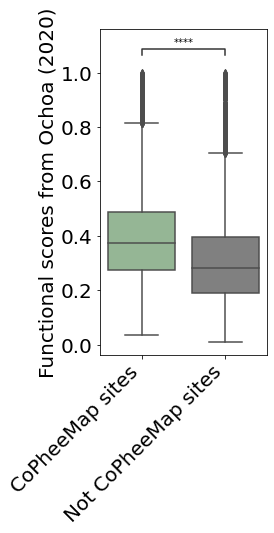

In [820]:
simi_pos=df_sites_pos_w_score.score.tolist()
simi_neg=df_sites_notin_network_pos_w_score.score.tolist()
df=pd.DataFrame({'Functional Scores':np.append(np.array(simi_pos),np.array(simi_neg)),
                 'Label':np.append(np.repeat('CoPheeMap sites',len(simi_pos)),
                                   np.repeat('Not CoPheeMap sites',len(simi_neg)))})
plt.figure(figsize=(3, 6))
x='Label'
y='Functional Scores'
ax = sns.boxplot(data=df,x=x,y=y,palette=['darkseagreen','grey'])
add_stat_annotation(ax, data=df, x=x, y=y,
                    box_pairs=[(('CoPheeMap sites','Not CoPheeMap sites'))],
                    test='t-test_ind', text_format='star', loc='inside', verbose=2)
plt.xticks(rotation=45,size=20,ha='right')
plt.yticks(size=20)
plt.xlabel('')
plt.ylabel('Functional scores from Ochoa (2020)',size=20)

plt.savefig('CoPheeMap/figures/Funscore_in_out_network_allpos.jpeg',bbox_inches='tight',dpi=300,pad_inches=0.1,optimize=True,orientation='portrait')
plt.show()

In [36]:
#LOO kinase validation
tmp=K_S_GPS[K_S_GPS['Gene name']=='CSNK2A2']
seqs=tmp.seq_15.tolist()
leave_out_sub=[s for s in All_sites if s.split('|')[3] in seqs]
tmp=pd.concat([network[network.index.isin(leave_out_sub)],network[network.site2.isin(leave_out_sub)]])

tmp.to_csv('CoPheeMap/LOO/CSNK2A2.csv')

In [37]:
df=pd.DataFrame()
df['nodes']=leave_out_sub
df['label']='CSNK2A2'
df.to_csv('CoPheeMap/LOO/CSNK2A2_sub.csv')

In [44]:
tmp=K_S_GPS[K_S_GPS['Gene name']=='CSNK2A1']
seqs=tmp.seq_15.tolist()
leave_out_sub=[s for s in All_sites if s.split('|')[3] in seqs]

sites_in_network=list(set(network.index.tolist()+network.site2.tolist()))
sites_tmp=list(set(sites_in_network).intersection(set(leave_out_sub)))

df=pd.DataFrame()
df['nodes']=sites_tmp
df['label']='CSNK2A1'

df.to_csv('CoPheeMap/LOO/CSNK2A1_sub_in_network.csv')

In [21]:
from collections import Counter

In [835]:
#Identification across cancer types
sites=list(set(network.index.tolist()+network.site2.tolist()))
s_cross_cancer1=[]
for i in range(len(tmp_new)):
    s_cross_cancer1=s_cross_cancer1+list(set(sites).intersection(tmp_new[i].index.tolist()))
c=Counter(s_cross_cancer1)
val=c.values()
val_c1=Counter(val)
s_cross_cancer2=[]
for i in range(len(tmp_new)):
    s_cross_cancer2=s_cross_cancer2+list((tmp_new[i].index.tolist()))
c=Counter(s_cross_cancer2)
val=c.values()
val_c2=Counter(val)

/var/folders/2k/p13z68bx7p9fvh4xn3mbjn_r0000gr/T/ipykernel_84213/1017022267.py:18: MatplotlibDeprecationWarning: 
The 'optimize' parameter of print_jpg() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use pil_kwargs={'optimize': ...} instead. If any parameter follows 'optimize', they should be passed as keyword, not positionally.
  plt.savefig('CoPheeMap/figures/network_sites_cross_cancer.jpeg',bbox_inches='tight',dpi=300,pad_inches=0.1,optimize=True,orientation='portrait')


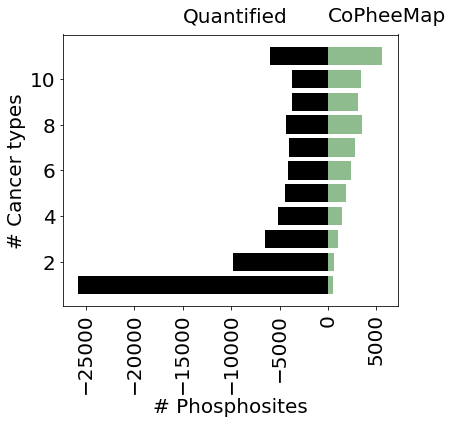

In [836]:
plt.figure(figsize=(6, 5))
x = "label"
y = "score"
hue = "random"

# plot the bars
plt.barh(range(11,0,-1), [val_c1[i] for i in range(11,0,-1)],color='darkseagreen')
plt.barh(range(11,0,-1), [-val_c2[i] for i in range(11,0,-1)],color='black')
#plt.title("Back-to-Back Bar Chart")
plt.text(-15000,12.5,'Quantified',size=20)
plt.text(0,12.5,'CoPheeMap',size=20)
#plt.bar(range(11,0,-1),[val_c[i] for i in range(11,0,-1)])
plt.xticks(size=20,rotation=90)
plt.yticks(size=20)
#plt.xlabel('# of cancer types',size=14)
plt.xlabel('# Phosphosites',size=20)
plt.ylabel('# Cancer types',size=20)
plt.savefig('CoPheeMap/figures/network_sites_cross_cancer.jpeg',bbox_inches='tight',dpi=300,pad_inches=0.1,optimize=True,orientation='portrait')
plt.show()

In [9]:
import networkx as nx
from operator import itemgetter
from networkx.algorithms import community

In [10]:
#CoPheeMap
seq1=[i.split('|')[3] for i in network.index.tolist()]
seq2=[i.split('|')[3] for i in network.site2.tolist()]
network['seq1']=np.array(seq1)
network['seq2']=np.array(seq2)
sites=list(set(network.index.tolist()+network.site2.tolist()))
G = nx.Graph()
elist=list(zip(network.index.tolist(),network.site2.tolist()))
G.add_edges_from(elist)

idx_ST=[]
idx_Y=[]
for i in range(len(network)):
    if network.seq1.iloc[i][7] in ['S','T']:
        idx_ST.append(i)
    if network.seq1.iloc[i][7] in ['Y']:
        idx_Y.append(i)
network_ST=network.iloc[idx_ST,:]
network_Y=network.iloc[idx_Y,:]
lst_ST=list(set(network_ST.index.tolist()+network_ST.site2.tolist()))
H=G.subgraph(lst_ST)
nodes_ST=max(nx.connected_components(H))
G_ST=G.subgraph(nodes_ST)
network_Y=network.iloc[idx_Y,:]
lst_Y=list(set(network_Y.index.tolist()+network_Y.site2.tolist()))
H=G.subgraph(lst_Y)
nodes_Y=max(nx.connected_components(H))
G_Y=G.subgraph(nodes_Y)

In [25]:
sites=list(set(network.index.tolist()+network.site2.tolist()))
len(sites)
len(network)

764049

In [ ]:
s1=[]
s2=[]
seq1=[]
seq2=[]
for i in range(len(combined_cancer_neg)):
    site1=combined_cancer_neg.index[i].split('*')[0]
    site2=combined_cancer_neg.index[i].split('*')[1]
    s1.append(site1)
    s2.append(site2)
    seq1.append(site1.split('|')[3])
    seq2.append(site2.split('|')[3])
combined_cancer_neg['site1']=np.array(s1)
combined_cancer_neg['site2']=np.array(s2)

combined_cancer_neg['seq1']=np.array(seq1)
combined_cancer_neg['seq2']=np.array(seq2)
neg_path=[]
for i in range(len(combined_cancer_pos)):
    try:
        neg_path.append(len(nx.shortest_path(G, source=combined_cancer_neg.site1.iloc[i], target=combined_cancer_neg.site2.iloc[i])))
    except:
        continue

pos_path=[]
for k in ks:
    ns=[]
    for node in G.nodes:
        try:
            if k in G.nodes[node]['kinase']:
                ns.append(node)
        except:
            continue

    if len(ns)>=3:
        for i in range(len(ns)-1):
            for j in range(i+1,len(ns)):
                try:
                    pos_path.append(nx.shortest_path_length(G, source=ns[i], target=ns[j]))
                except:
                    continue

plt.figure(figsize=(8, 5))
c1=Counter(pos_path)
c2=Counter(neg_path)
# plot the bars
plt.barh(range(6,0,-1), [c1[i] for i in range(6,0,-1)],color='lightcoral')
plt.barh(range(6,0,-1), [-c2[i] for i in range(6,0,-1)],color='grey')
#plt.title("Back-to-Back Bar Chart")

#plt.bar(range(11,0,-1),[val_c[i] for i in range(11,0,-1)])
plt.xticks(size=14)
plt.yticks(size=20)
#plt.xlabel('# of cancer types',size=14)
plt.xlabel('# of phosphosite pairs',size=20)
plt.ylabel('Shortest path length',size=20)
plt.legend(['positive','negative'],loc='best',fontsize=16)
plt.savefig('CoPheeMap/figures/path_posneg_ST.jpeg',bbox_inches='tight',dpi=300,pad_inches=0.1,optimize=True,orientation='portrait')
plt.show()

In [ ]:
kin_dict={}
for node in G.nodes:
    tmp=K_S_GPS[K_S_GPS.seq_15.isin([node.split('|')[3]])]
    if len(tmp)>0:
        kin_dict[node]=list(set(tmp['Gene name']))
degree_dict = dict(G.degree(G.nodes()))
nx.set_node_attributes(G, kin_dict, 'kinase')
for k in ks:
    ns=[]
    for node in G.nodes:
        try:
            if k in G.nodes[node]['kinase']:
                ns.append(node)
        except:
            pass
    tmp=network_ST[network_ST.index.isin(ns)]
    tmp=tmp[tmp.site2.isin(ns)]
    if len(tmp)>0:
        G_CDK2 = nx.Graph()
        elist=list(zip(tmp.index.tolist(),tmp.site2.tolist()))
        G_CDK2.add_edges_from(elist)
        pos = nx.kamada_kawai_layout(G_CDK2)  # Seed layout for reproducibility
        nx.draw(G_CDK2, pos=pos, with_labels=False)
        plt.title(k,size=14)
        name=''.join(['CoPheeMap/data_construction/model_all_pos/known_subs/network_',k,'.jpeg'])
        plt.savefig(name,bbox_inches='tight',dpi=300,pad_inches=0.1,optimize=True,orientation='portrait')
        plt.show()

In [13]:
degree_dict = dict(G.degree(G.nodes()))
nx.set_node_attributes(G, degree_dict, 'degree')

In [12]:
import math

/var/folders/2k/p13z68bx7p9fvh4xn3mbjn_r0000gr/T/ipykernel_55795/3348089872.py:14: MatplotlibDeprecationWarning: 
The 'optimize' parameter of print_jpg() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use pil_kwargs={'optimize': ...} instead. If any parameter follows 'optimize', they should be passed as keyword, not positionally.
  plt.savefig('CoPheeMap/figures/all_Degree_distribution.jpeg',bbox_inches='tight',dpi=300,pad_inches=0.1,optimize=True,orientation='portrait')


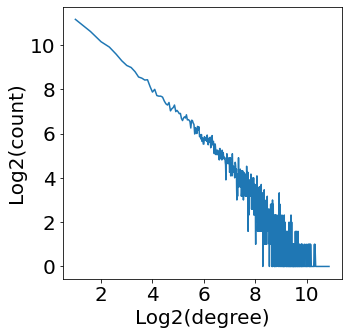

In [39]:
lst=list(degree_dict.values())
c=Counter(lst)
sorted_c=sorted(c.items(), key=itemgetter(0), reverse=True)
sorted_c=sorted_c[:-1]

plt.figure(figsize=(5, 5))
plt.plot([math.log2(i[0]) for i in sorted_c],[math.log2(i[1]) for i in sorted_c])
#sns.distplot(list(degree_dict.values()))
#plt.plot([math.log(61),math.log(61)],[0,6],linestyle = 'dotted',color='black')
plt.xticks(size=20)
plt.yticks(size=20)
plt.xlabel('Log2(degree)',size=20)
plt.ylabel('Log2(count)',size=20)
plt.savefig('CoPheeMap/figures/all_Degree_distribution.jpeg',bbox_inches='tight',dpi=300,pad_inches=0.1,optimize=True,orientation='portrait')
plt.show()

In [23]:
dgs1=[]
dgs2=[]
for n in G.nodes:
    if n.split('|')[3] in K_S_GPS.seq_15.tolist():
        dgs1.append(math.log10(G.nodes[n]['degree']))
    else:
        dgs2.append(math.log10(G.nodes[n]['degree']))

In [39]:
nds=[]
for n in G.nodes:
    if n.split('|')[3] not in K_S_GPS.seq_15.tolist():
        nds.append(n)

In [30]:
dgs=[]
nds=[]
for n in G.nodes:
    if n.split('|')[3] not in K_S_GPS.seq_15.tolist():
        if G.nodes[n]['degree'] > 500:
            dgs.append(G.nodes[n]['degree'])
            nds.append(n)

In [33]:
file_name='CoPheeMap/data_construction/dark_site.csv'
with open(file_name, 'w') as fp:
    for s in range(len(dgs)):
        fp.write("%s\t" % nds[s])
        fp.write("%s\n" % dgs[s])

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Annotated sites v.s. Dark sites: t-test independent samples with Bonferroni correction, P_val=6.972e-18 stat=8.622e+00


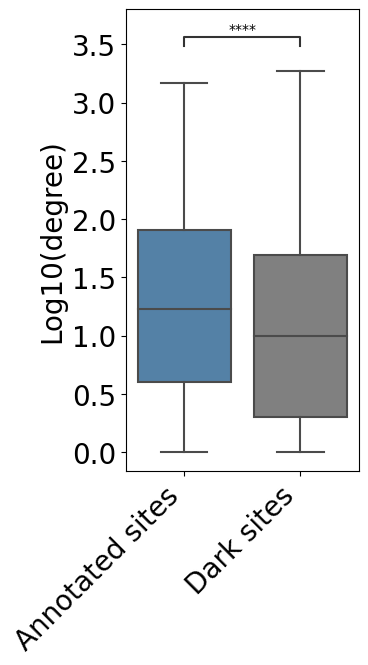

In [26]:
df=pd.DataFrame({'Degree':np.append(np.array(dgs1),np.array(dgs2)),
                 'Label':np.append(np.repeat('Annotated sites',len(dgs1)),
                                   np.repeat('Dark sites',len(dgs2)))})
plt.figure(figsize=(3, 6))
x='Label'
y='Degree'
ax = sns.boxplot(data=df,x=x,y=y,palette=['steelblue','grey'])
add_stat_annotation(ax, data=df, x=x, y=y,
                    box_pairs=[(('Annotated sites','Dark sites'))],
                    test='t-test_ind', text_format='star', loc='inside', verbose=2)
plt.xticks(rotation=45,size=20,ha='right')
plt.yticks(size=20)
plt.xlabel('')
plt.ylabel('Log10(degree)',size=20)

plt.savefig('CoPheeMap/figures/annotated_dark_degree.jpeg',bbox_inches='tight',dpi=300,pad_inches=0.1,orientation='portrait')
plt.show()

In [879]:
import shap

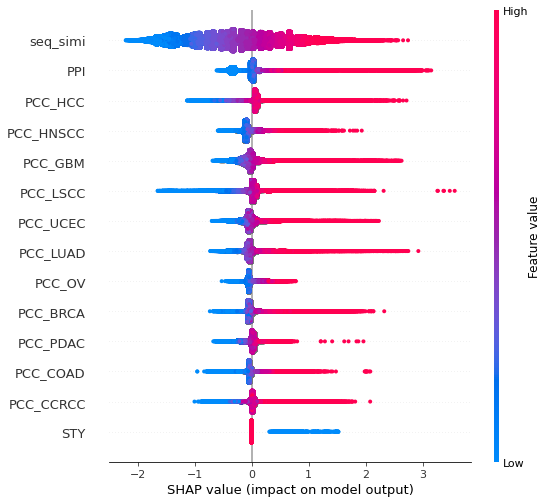

In [883]:
#Shapley values
explainer = shap.Explainer(bst)
shap_values = explainer(X_test)

f = plt.figure()
shap.summary_plot(shap_values, X_test)
f.savefig("CoPheeMap/figures/summary_shapley_CoPheeMap.png", bbox_inches='tight', dpi=600)


The 'optimize' parameter of print_jpg() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use pil_kwargs={'optimize': ...} instead. If any parameter follows 'optimize', they should be passed as keyword, not positionally.


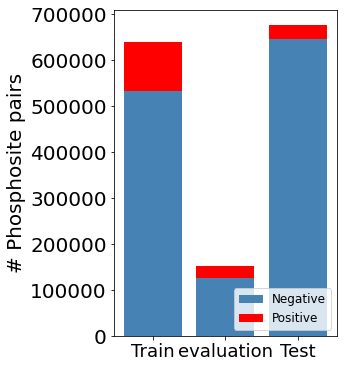

In [896]:
plt.figure(1, figsize=(4,6))
plt.bar(['Train','evaluation','Test'],[5*len(data_pos_train_train),5*len(data_pos_train_eval),len(y_test[y_test['0']==0])], color='steelblue')
plt.bar(['Train','evaluation','Test'],[len(data_pos_train_train),len(data_pos_train_eval),len(y_test[y_test['0']==1])],
        bottom=[5*len(data_pos_train_train),5*len(data_pos_train_eval),len(y_test[y_test['0']==0])], color='red')
plt.xticks(size=18)
plt.yticks(size=20)
plt.ylabel("# Phosphosite pairs",size=20)

plt.legend(['Negative','Positive'],fontsize=12,loc='lower right')
plt.savefig('CoPheeMap/figures/pos_neg.jpeg',bbox_inches='tight',dpi=300,pad_inches=0.1,optimize=True,orientation='portrait')
plt.show()

In [29]:
sites_cophee=list(set(network.index.tolist()+network.site2.tolist()))

In [81]:
list1=np.array([])
tumor1=np.array([])
for i in range(len(tmp_new)):
    data=tmp_new[i]
    data_cophee=data[data.index.isin(sites_cophee)]
    median_val=data_cophee.median(axis=1).values
    list1=np.append(list1,median_val)
    tumor1=np.append(tumor1, np.repeat(Names[i],len(data_cophee)))
label1=np.repeat('CoPheeMap sites',len(list1))

list2=np.array([])
tumor2=np.array([])
for i in range(len(tmp_new)):
    data=tmp_new[i]
    data_not_cophee=data[~data.index.isin(sites_cophee)]
    median_val=data_not_cophee.median(axis=1).values
    list2=np.append(list2,median_val)
    tumor2=np.append(tumor2, np.repeat(Names[i],len(data_not_cophee)))
label2=np.repeat('Not CoPheeMap sites',len(list2))

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

PDAC_CoPheeMap sites v.s. PDAC_Not CoPheeMap sites: t-test independent samples with Bonferroni correction, P_val=0.000e+00 stat=7.286e+01
UCEC_CoPheeMap sites v.s. UCEC_Not CoPheeMap sites: t-test independent samples with Bonferroni correction, P_val=0.000e+00 stat=1.030e+02
OV_CoPheeMap sites v.s. OV_Not CoPheeMap sites: t-test independent samples with Bonferroni correction, P_val=0.000e+00 stat=5.532e+01
CCRCC_CoPheeMap sites v.s. CCRCC_Not CoPheeMap sites: t-test independent samples with Bonferroni correction, P_val=0.000e+00 stat=7.235e+01
BRCA_CoPheeMap sites v.s. BRCA_Not CoPheeMap sites: t-test independent samples with Bonferroni correction, P_val=0.000e+00 stat=6.829e+01
COAD_CoPheeMap sites v.s. COAD_Not CoPheeMap sites: t-test independent samples with Bonferroni correction, P_val=0.000e+00 stat=4.677e+01
GBM_CoPhee

/var/folders/2k/p13z68bx7p9fvh4xn3mbjn_r0000gr/T/ipykernel_16164/1969187686.py:29: MatplotlibDeprecationWarning: 
The 'optimize' parameter of print_jpg() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use pil_kwargs={'optimize': ...} instead. If any parameter follows 'optimize', they should be passed as keyword, not positionally.
  plt.savefig('CoPheeMap/figures/Abundance_in_out_network_allpos.jpeg',bbox_inches='tight',dpi=300,pad_inches=0.1,optimize=True,orientation='portrait')


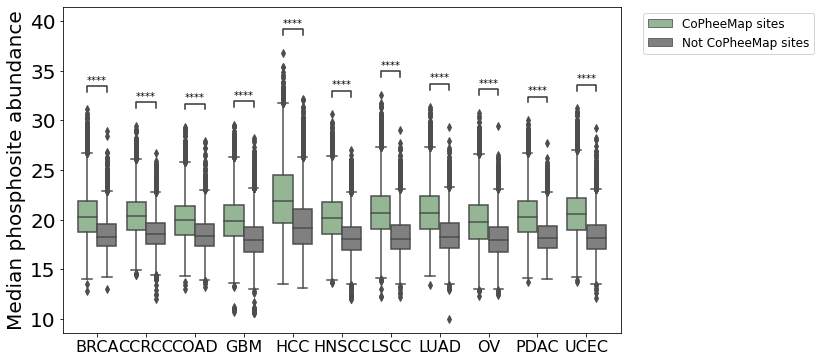

In [84]:
df={'Abundance':np.append(list1,list2),'tumor':np.append(tumor1,tumor2),
    'label':np.append(label1,label2)}
df=pd.DataFrame(df)

plt.figure(figsize=(10, 6))
x = "tumor"
y = "Abundance"
hue = "label"
ax = sns.boxplot(data=df, x=x, y=y, hue=hue, palette=['darkseagreen','grey'])
add_stat_annotation(ax, data=df, x=x, y=y, hue=hue,
                    box_pairs=[(("BRCA", "CoPheeMap sites"), ("BRCA", "Not CoPheeMap sites")),
                                 (("CCRCC", "CoPheeMap sites"), ("CCRCC", "Not CoPheeMap sites")),
                                 (("COAD", "CoPheeMap sites"), ("COAD", "Not CoPheeMap sites")),
                                 (("GBM", "CoPheeMap sites"), ("GBM", "Not CoPheeMap sites")),
                                 (("HCC", "CoPheeMap sites"), ("HCC", "Not CoPheeMap sites")),
                                 (("HNSCC", "CoPheeMap sites"), ("HNSCC", "Not CoPheeMap sites")),
                                 (("LSCC", "CoPheeMap sites"), ("LSCC", "Not CoPheeMap sites")),
                                 (("LUAD", "CoPheeMap sites"), ("LUAD", "Not CoPheeMap sites")),
                                 (("OV", "CoPheeMap sites"), ("OV", "Not CoPheeMap sites")),
                                 (("PDAC", "CoPheeMap sites"), ("PDAC", "Not CoPheeMap sites")),
                                 (("UCEC", "CoPheeMap sites"), ("UCEC", "Not CoPheeMap sites"))
                                ],
                    test='t-test_ind', text_format='star', loc='inside', verbose=2)
plt.xticks(size=16)
plt.yticks(size=20)
plt.xlabel('')
plt.ylabel('Median phosphosite abundance',size=20)
plt.legend(loc='upper left', bbox_to_anchor=(1.03, 1),fontsize=12)
plt.savefig('CoPheeMap/figures/Abundance_in_out_network_allpos.jpeg',bbox_inches='tight',dpi=300,pad_inches=0.1,optimize=True,orientation='portrait')
plt.show()